In [1]:
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import linear_model
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In this question, we will heavily use plots for examining  distrbituion of the features for treat and control groups. In order to have modularity and cleaner code, following functions are written for plotting numerical and categorical features in the data. We use seaborn instead of matplotlib for its more advanced visualization capabilities.

In [2]:
# functions for plotting numerical features
def plot_numerical_features(control, treat, column):
    '''
    Given dataframes control and treat, data in the given column will be plotted.
    For both dataframes histogram, kernel densirt estimator plot and boxplot will be plotted.
    '''
    fig, axes = plt.subplots(3,2, figsize=(20, 18))
    # plot for control
    sns.distplot(control[column], ax=axes[0,0], bins=20, kde=False, rug=True).set_title("Treat 0, {} Histogram".format(column))
    sns.kdeplot(control[column], ax=axes[1,0]).set_title("Treat 0, {} Kernel Density estimation".format(column))
    sns.boxplot(y=control[column], ax=axes[2,0]).set_title("Treat 0, {} Boxplot".format(column))
    # plot for treat
    sns.distplot(treat[column], ax=axes[0,1], bins=20, kde=False, rug=True).set_title("Treat 1, {} Histogram".format(column))
    sns.kdeplot(treat[column], ax=axes[1,1]).set_title("Treat 1, {} Kernel Density estimation".format(column))
    sns.boxplot(y=treat[column], ax=axes[2,1]).set_title("Treat 1, {} Boxplot".format(column))
    
    
def plot_two_histograms(control, treat, column):
    '''
    Given dataframes control and treat, data in the given column will be plotted.
    For both dataframes histogram of column will be plotted on the same figure
    '''
    fig, axes = plt.subplots(1,1, figsize=(20, 12))
    # find start and end for histogram bins
    minn = int(min(control[column].min(), treat[column].min()))
    maxx = int(max(control[column].max(), treat[column].max()))
    # plot histograms
    sns.distplot(control[column], ax=axes, bins=np.linspace(minn, maxx, 20), kde=False, rug=True, norm_hist=True, label=["Treat 0"])
    sns.distplot(treat[column], ax=axes, bins=np.linspace(minn, maxx, 20), kde=False, rug=True, norm_hist=True, label=["Treat 1"]).set_title("Normalized Histogram of Treat 0 and Treat 1, {}".format(column))
    axes.legend(prop={'size': 20})

# functions for plotting categorical features
def find_race_proportions(df):
    '''
    Given dataframe, assuming black and hispanic columns exist and each person has exactly one race; 
    white, black, hispanic ratios will be returned
    '''
    # find counts; total, black and hispanic
    total_count = df.black.count()
    black_count = df.black.sum()
    hispanic_count = df.hispan.sum()
    # assuming race = one of white, black, hispanic
    white_count = total_count - black_count - hispanic_count
    # find ratios
    return white_count/total_count, black_count/total_count, hispanic_count/total_count

def find_proportions(df, column):
    '''
    Given dataframe and column, assuming column has binary feature; return ratio in that column
    '''
    col = df[column]
    return [col.sum()/col.count()]

def plot_categorical_features(control, treat, columns):
    '''
    Given dataframes control and treat, data in the given columns will be plotted.
    For both dataframes and each column in columns, barplot will be plotted.
    '''
    fig, axes = plt.subplots(1,2, figsize=(20, 12))
    axes[0].set(ylim=(0, 1))
    axes[1].set(ylim=(0, 1))
    
    # make sure columns are handled
    control_proportions = []
    treat_proportions = []
    for col in columns:
        # handle column names
        if col == "white":
            control_proportions.extend(find_race_proportions(control))
            treat_proportions.extend(find_race_proportions(treat))
        if col == "married" or col == "nodegree":
            control_proportions.extend(find_proportions(control, col))
            treat_proportions.extend(find_proportions(treat, col))
    
    # plot for control
    sns.barplot(x=columns, y=control_proportions, ax=axes[0], orient="v").set_title("Treat 0, {} Barplot".format(columns))
    # plot for treat
    sns.barplot(x=columns, y=treat_proportions, ax=axes[1], orient="v").set_title("Treat 1, {} Barplot".format(columns))

Steps

1) Read the data from "lalonde.csv" using read_csv() functionality of pandas.

2) Split it into treat and control dataframes on "treat" column of the data.

In [3]:
data = pd.read_csv("lalonde.csv")

In [4]:
data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


Split data into two groups on "treat" feature

In [5]:
control = data[data['treat'] == 0]
treat = data[data['treat'] == 1]

In [6]:
control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


In [7]:
treat.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

**Steps**

1) Check distribution of "re78" in control and treat groups using describe() functionality of pandas.

2) Check distribution of "re78" in control and treat groups using plot_numerical_features and plot_two_histograms functions given above.

3) Make comments about the results.

Check distribution of "re78" in control and treat groups using describe() functionality of pandas. It gives number of elements, mean, standard deviation, minimun and maximum value, median, 25% and 75% percentiles for given feature.

In [10]:
control["re78"].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [11]:
treat["re78"].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

Check distribution of "re78" in control and treat groups using plots. For both treat and control groups separate histogram with rugs, kernel density estimator ans boxplot are plotted. For more clear comparison, unified and normalized histogram is also given. 

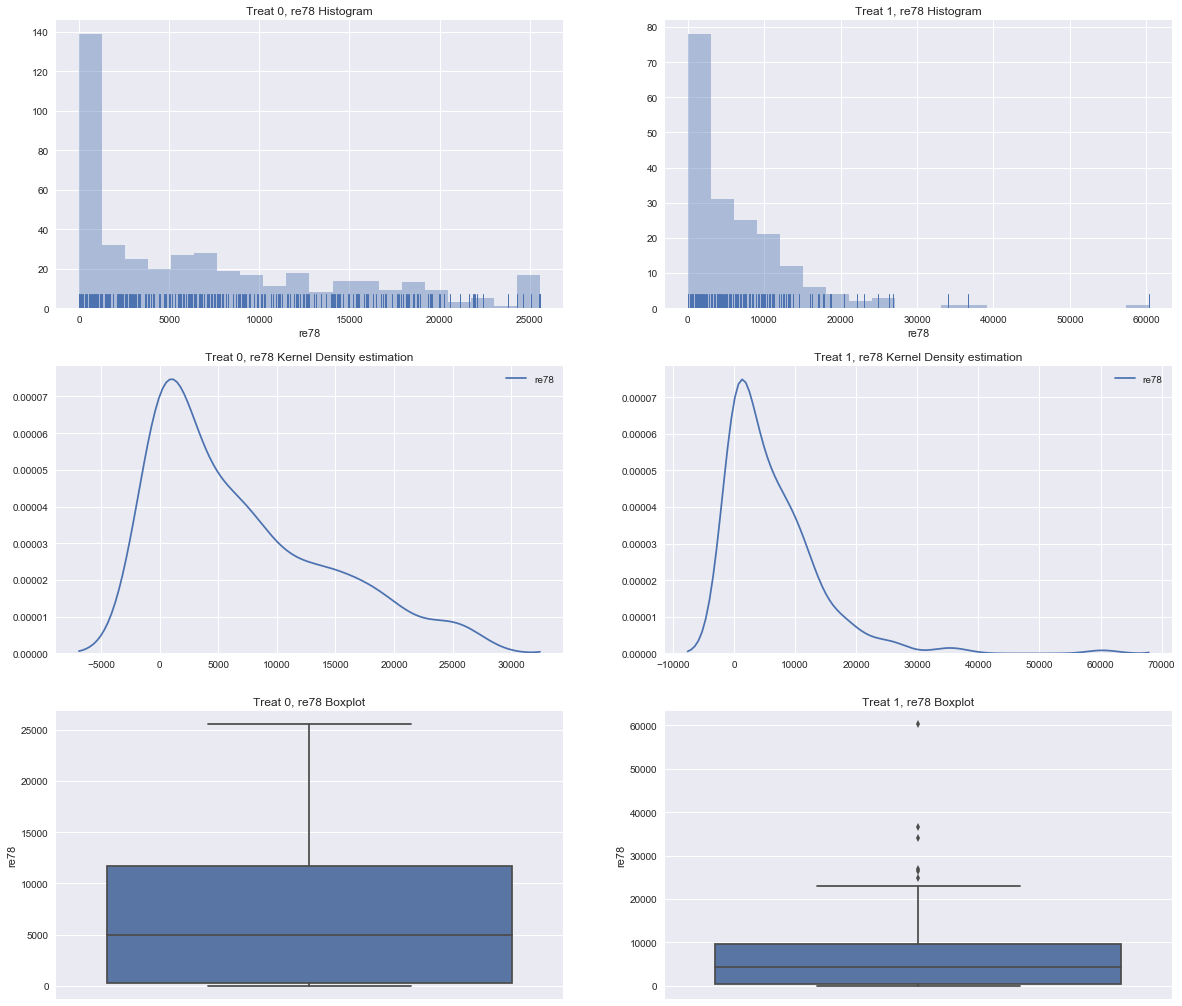

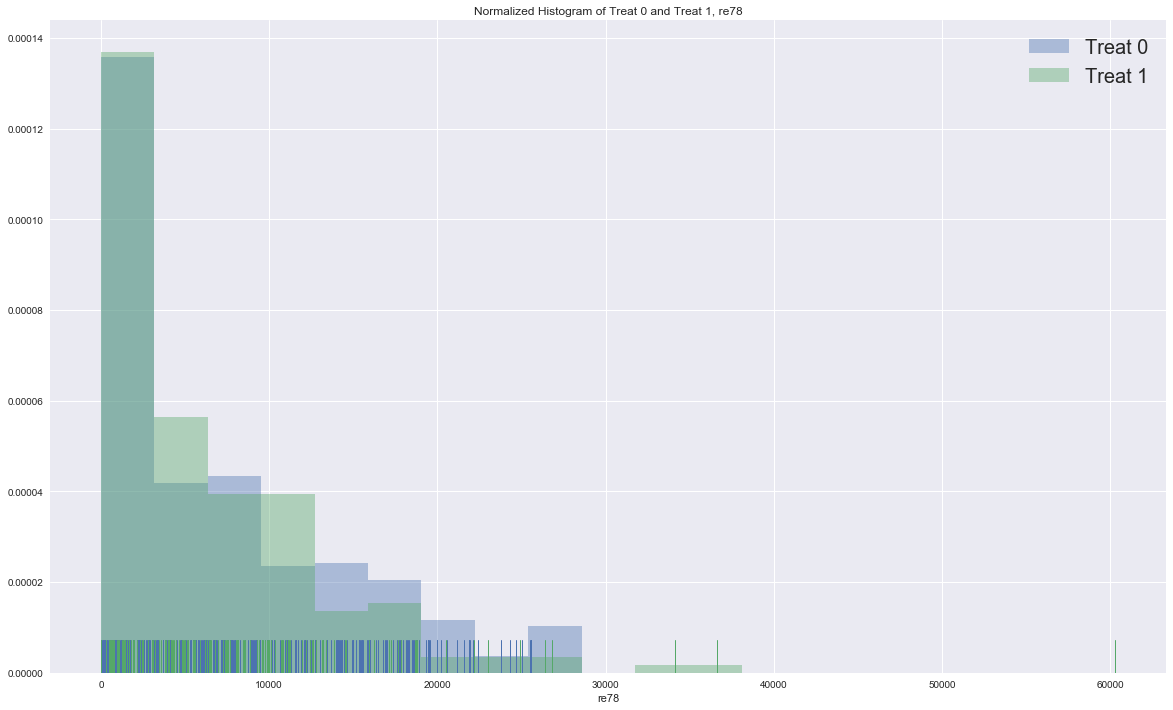

In [12]:
plot_numerical_features(control, treat, "re78")
plot_two_histograms(control, treat, "re78")

As one can see from numerical figures, number of people in treat group (185 people) is significantly lower than control group (429 people). Although treat group's maximum value (60307.93) is much higher than control group's maximum value (25564.67), its mean is almost 10% lower than control group. Histograms of treat and control groups look alike, but we see that around left and right of the plot treat group is more populating whereas control group have more frequency of people around mid of the plot. Same thing can also be seen in kernel density estimation and boxplot. A naive "researcher" might conclude that "job training program is ineffective, more severely it has negative effect on salaries of people in the following years" by just comparing mean salary of people in treat and control groups (Note that, in the treat group mean salary in 1978 is lower than control group). However, having learned about the proper observational studies we know that one should check distribution of other features in treat and control groups before reaching a conclusion by just examining numerical values and plots of outcome. 

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

**Steps**

1) Check distribution of features in control and treat groups using describe() functionality of pandas.

2) Check distribution of features in control and treat groups using plot_numerical_features and plot_two_histograms functions given above.

3) Make comments about the results.

Check distribution of features in control and treat groups using describe() functionality of pandas. It gives number of elements, mean, standard deviation, minimun and maximum value, median, 25% and 75% percentiles for given feature.

In [13]:
control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


In [14]:
treat.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


Check distribution of features in control and treat groups using plots. Different comparisons for categorical and numerical features are provided. 

For categorical features, their ratios in the data are plotted in single boxplot for both treat and control groups. 

For each numerical feature, separate histogram with rugs, kernel density estimator ans boxplot are plotted for both treat and control groups. For more clear comparison, unified and normalized histogram is also given. 

### 2.1. Categorical Features

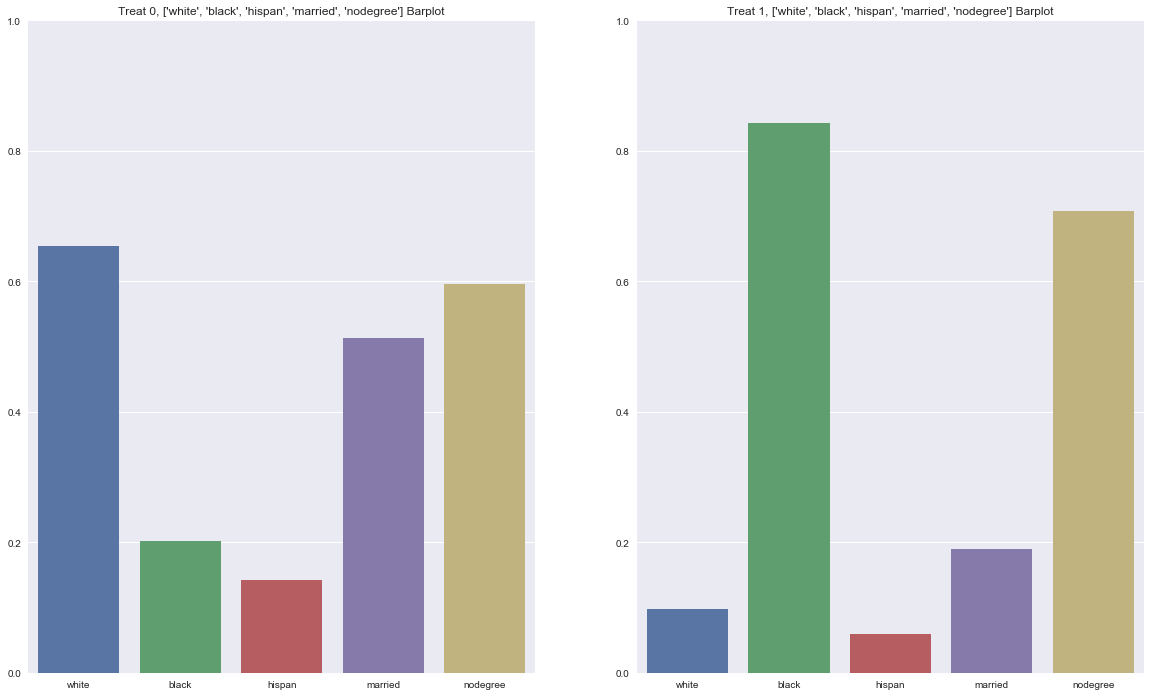

In [15]:
categorical_features = ["white", "black", "hispan", "married", "nodegree"]

plot_categorical_features(control, treat, categorical_features)

### 2.2. Numerical Features

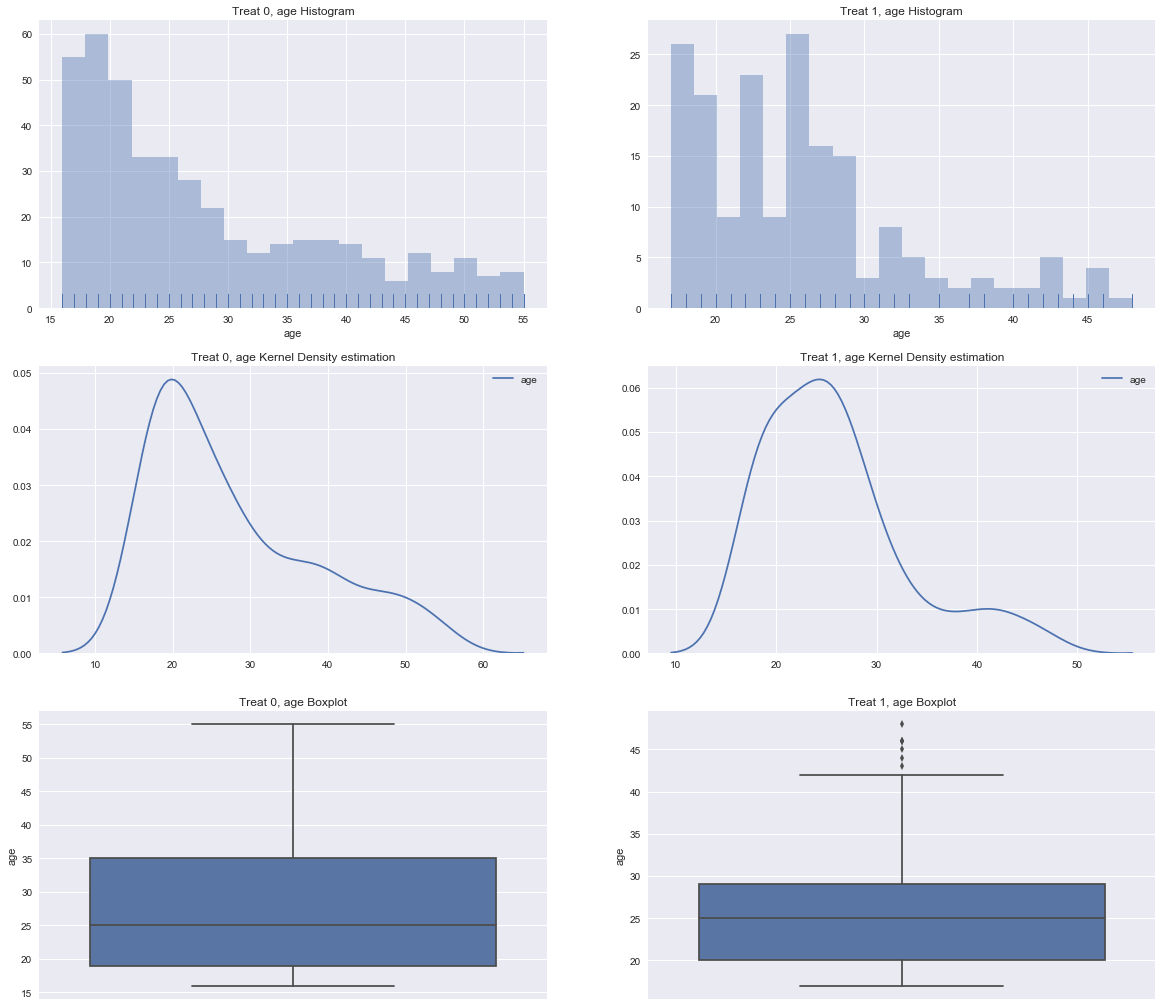

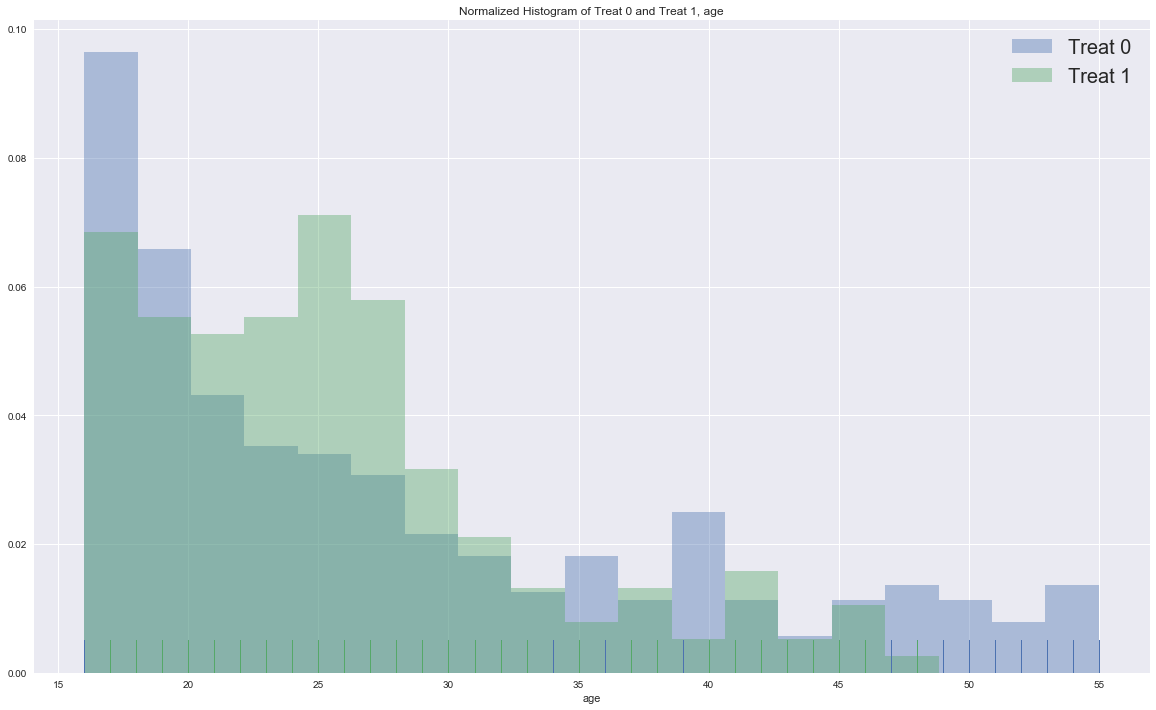

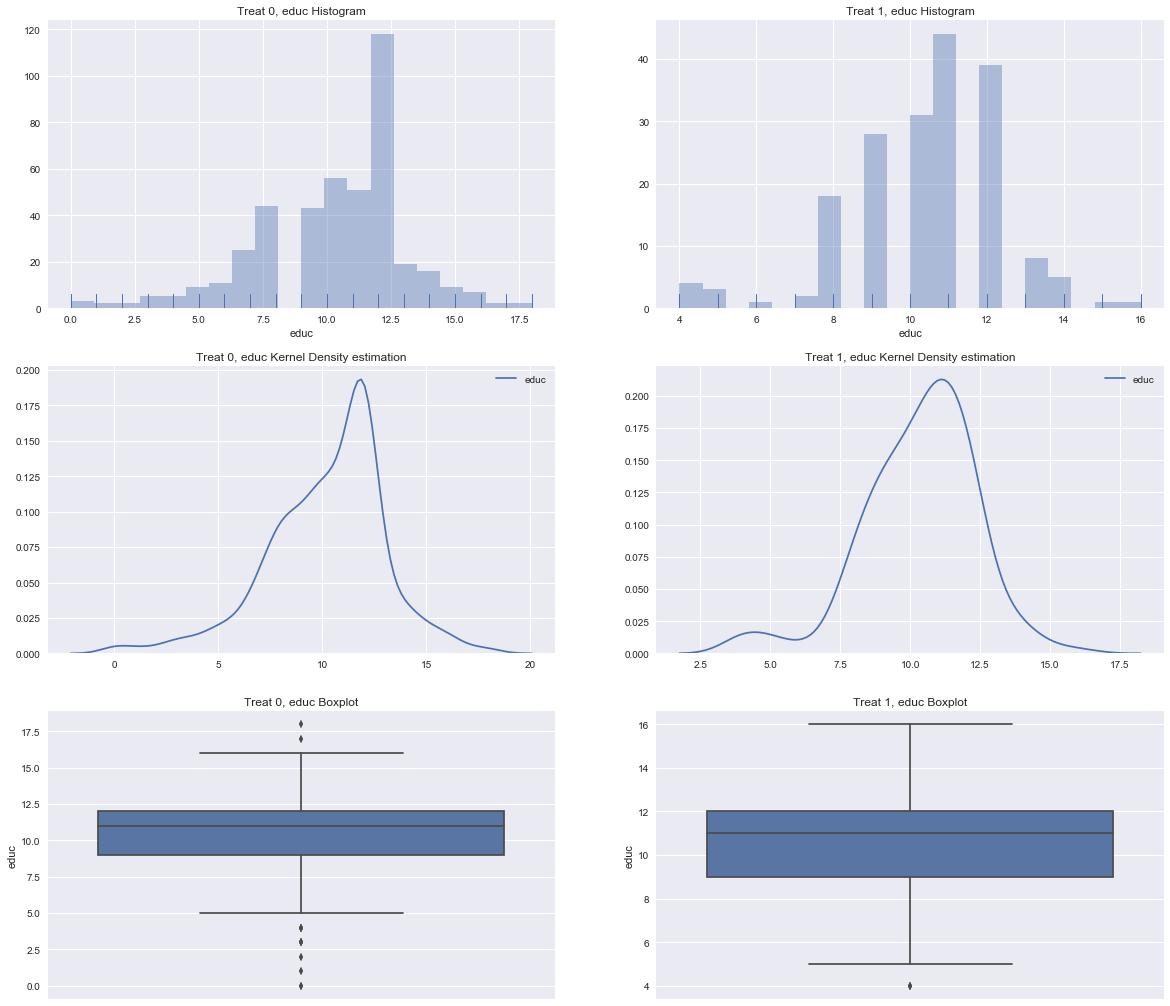

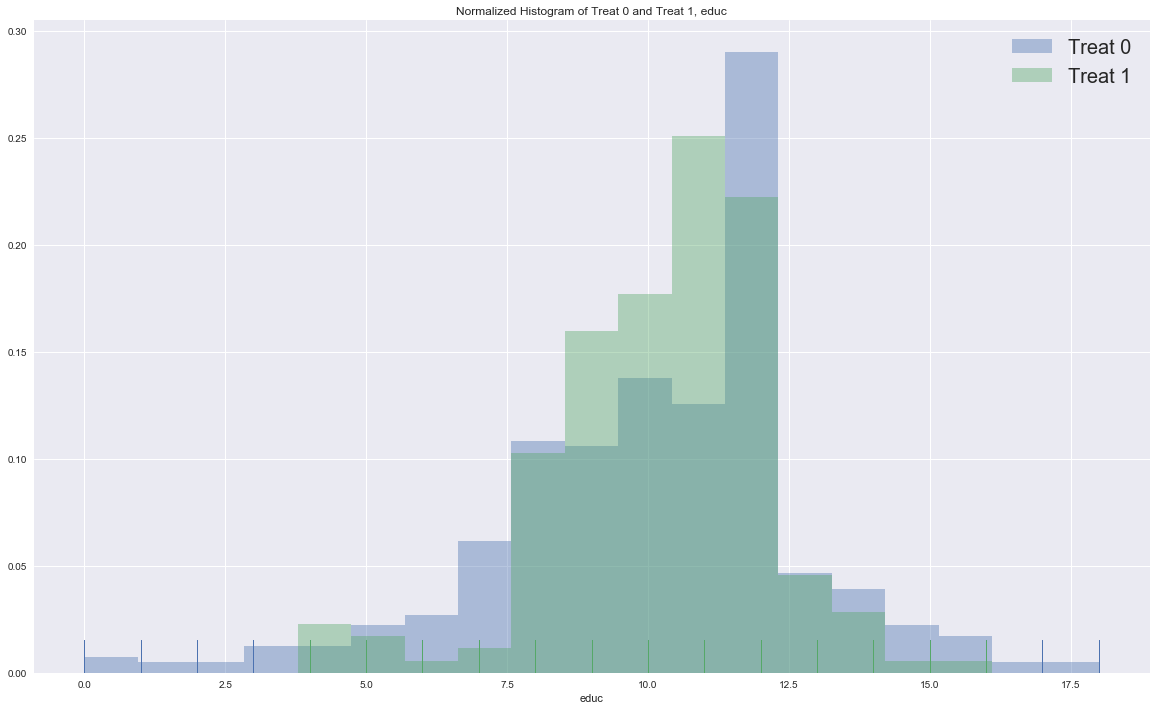

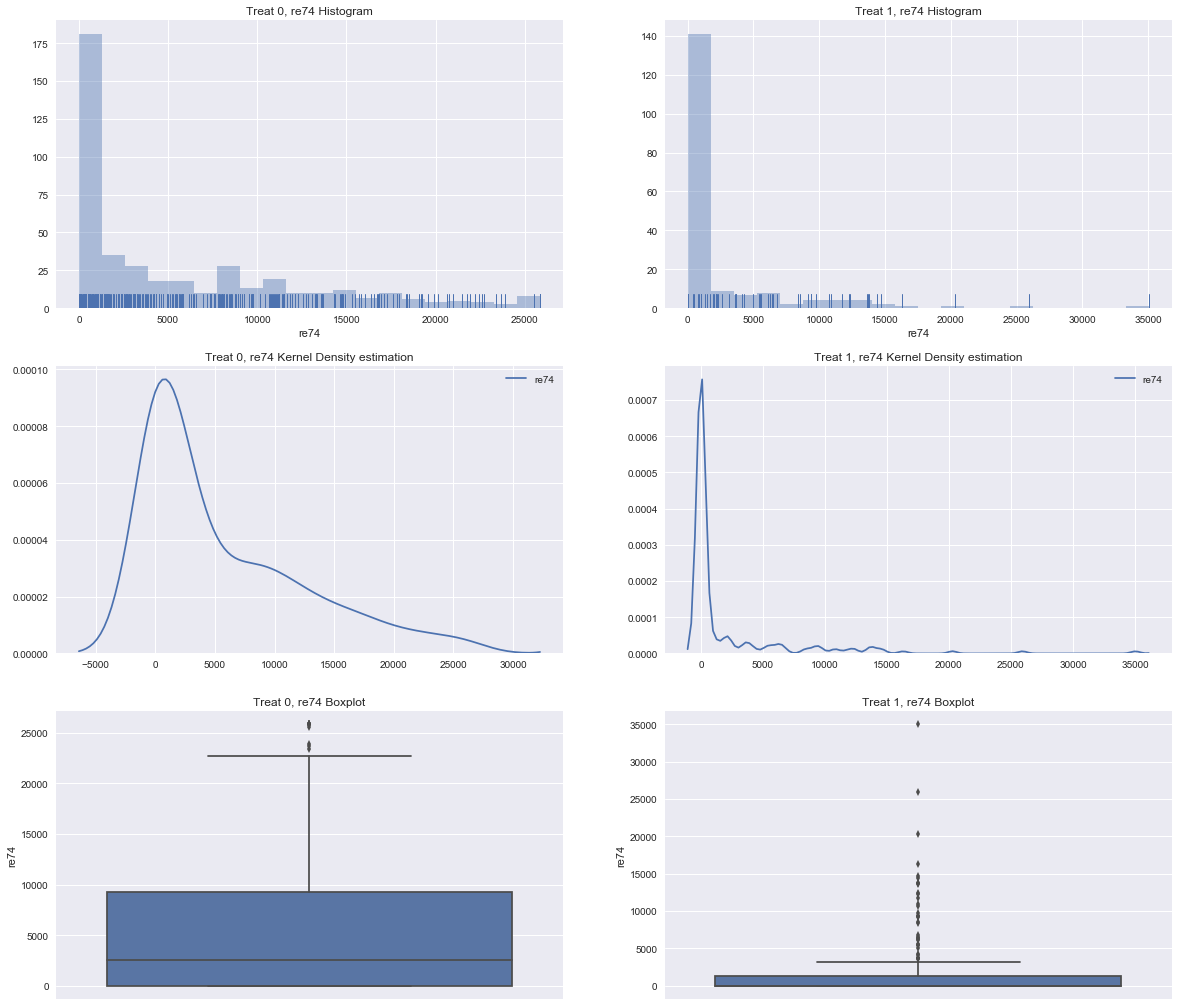

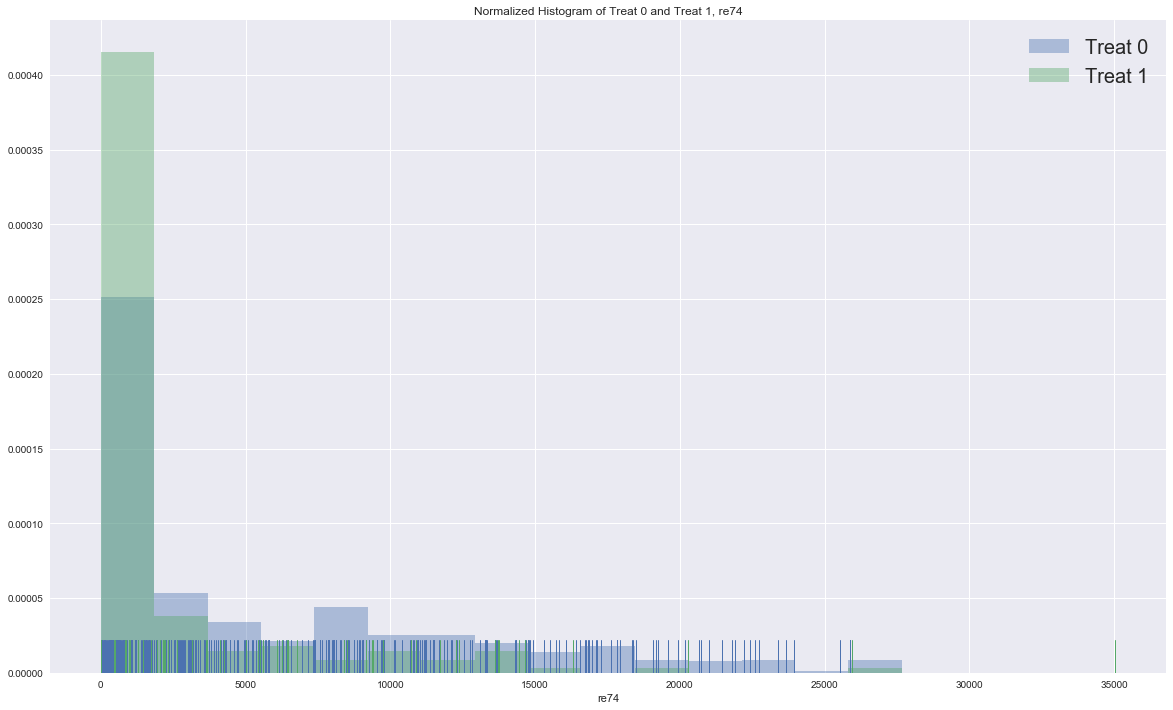

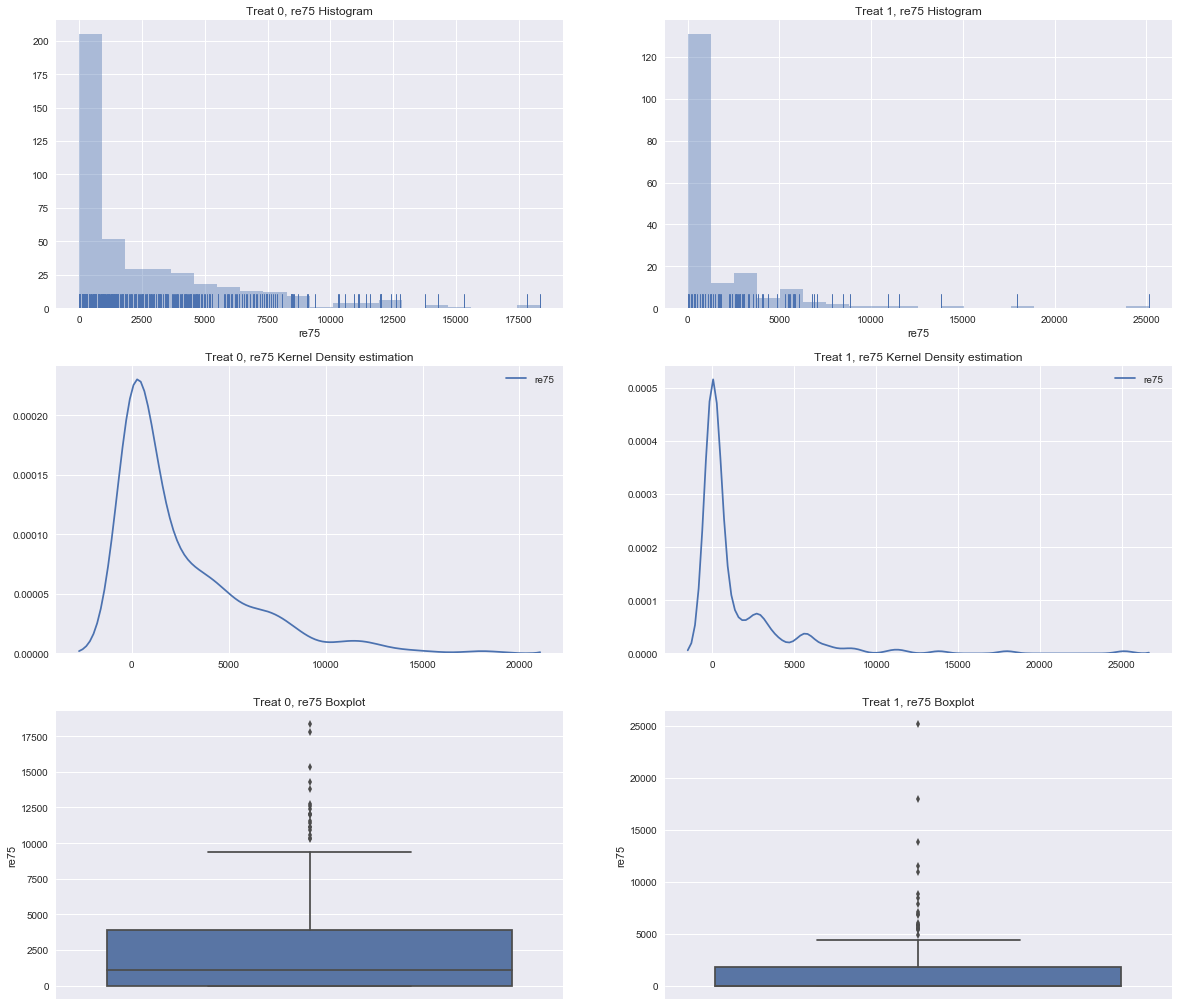

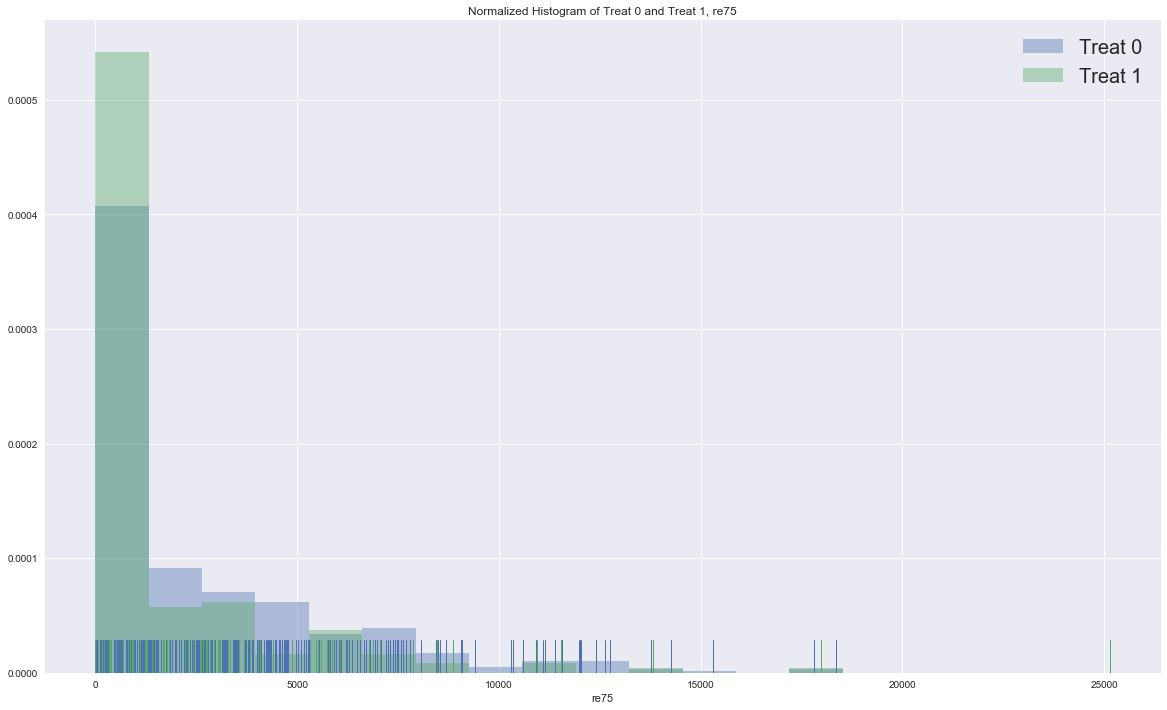

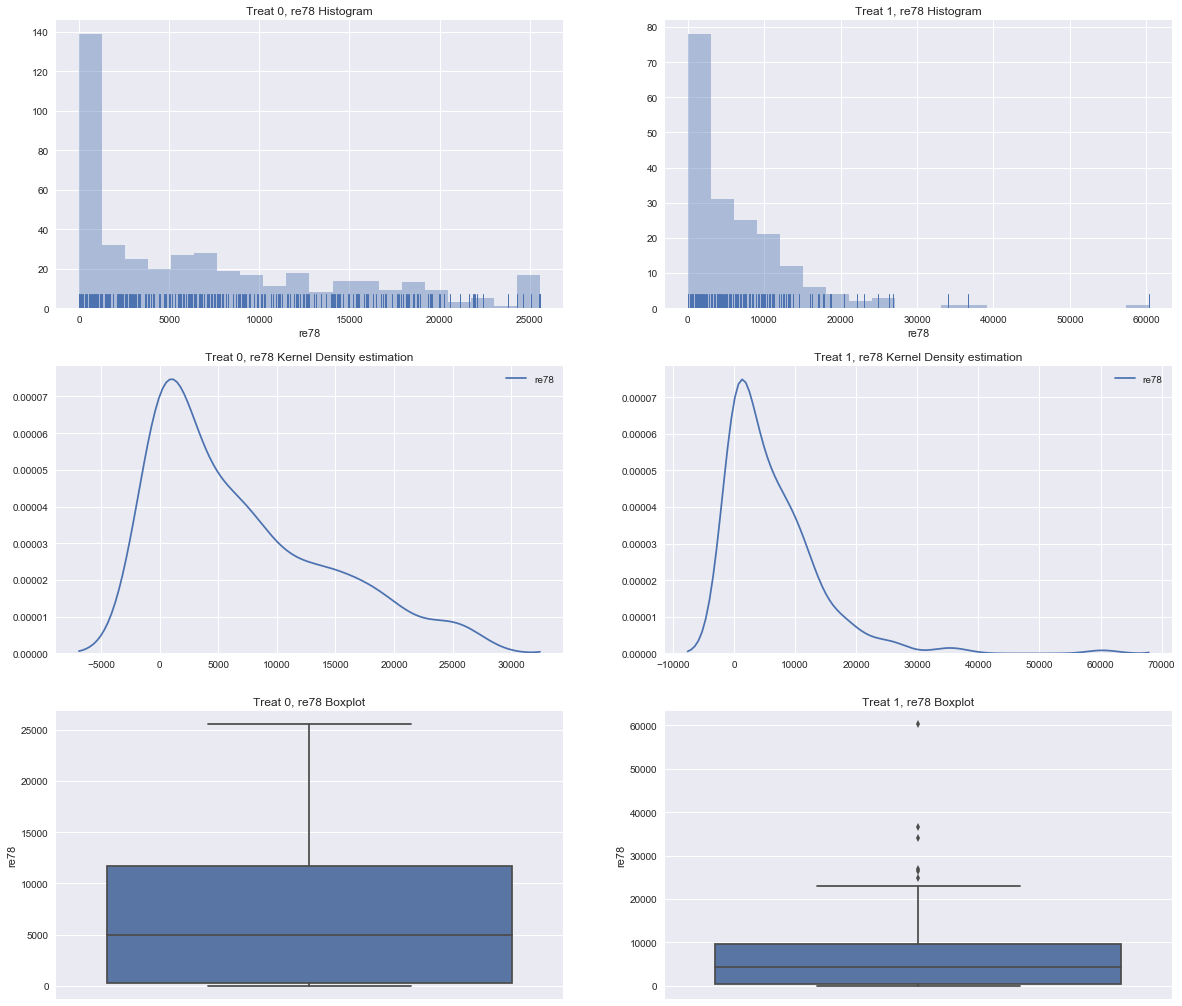

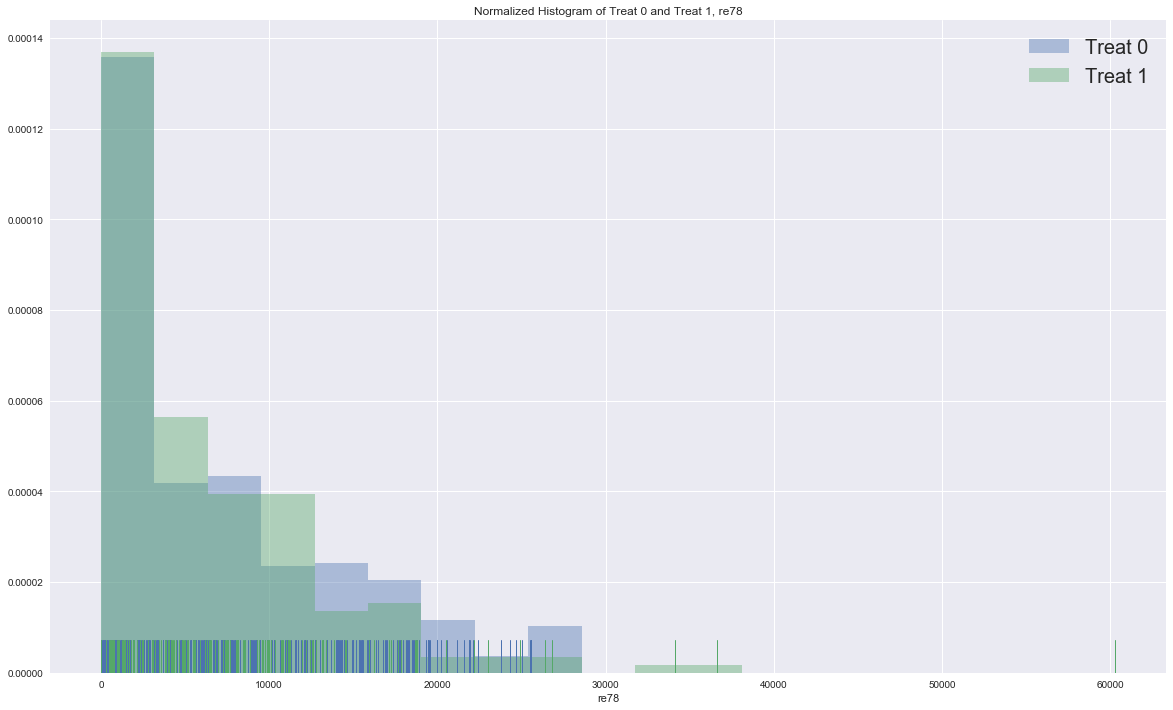

In [16]:
numerical_features = ["age", "educ", "re74", "re75", "re78"]

for col in numerical_features:
    plot_numerical_features(control, treat, col)
    plot_two_histograms(control, treat, col)

By looking at the numerical values and plots of the features, one can see that treat and control group have very different distributions for their features. 

For age distribution even means are very different, 28 for control and 25.8 treat groups. Moreover, examining the plots, we see that for control group the left and right of the plot are more populated which means that there are more young and more old people in control group whereas ratio of mid age people is significantly higher in treat group. Note that, there are very few old people in treat group whereas there are quite a few old people in control group. Summing all up, distribution of age feature is very different for treat and contol groups which should prevent naive researcher to make a conclusion about effectiveness of job training program by just examining outcome "re78". 

For education distribution means are very similar, 10.23 for control and 10.36 treat groups. Moreover, examining the plots, we see that for control group the left and right of the plot are more populated which means that there are more less educated and more very educated people in control group whereas ratio of somewhat educated (around 10 years) people is significantly higher in treat group. Note that, in the both end of the histogram all people are from control group which means that distribution of education feature is very different for treat and contol groups which should prevent naive researcher to make a conclusion about effectiveness of job training program by just examining outcome "re78". 

For re74 distribution means are very far away, 5620 for control and 2095 treat groups (control group earns almost 3 fold of treat group) although treat group's maximum (35040) is much higher than control group's maximum (25862). By looking at the histogram, we see that each group has lots of unemployed people (with salary 0), but number of unemployed people in treat group is almost the twice of number of unemployed people in control group. Intuitively, one would expect that person earning a lot in 1974 is more likely to earn a lot in 1978 which means that reaching a conclusion about job training program's effectiveness by just comparing salaries in 1978 without first making sure that other features are distributed similarly is prone to error.

For re75 distribution means are very far away, 2466 for control and 1532 treat groups (control group earns more than 150% of treat group) although treat group's maximum (25142) is much higher than control group's maximum (18347). By looking at the histogram, we see that each group has lots of unemployed people (with salary 0), but number of unemployed people in treat group is significantly higher number of unemployed people in control group. Intuitively, one would expect that person earning a lot in 1975 is more likely to earn a lot in 1978 which means that reaching a conclusion about job training program's effectiveness by just comparing salaries in 1978 without first making sure that other features are distributed similarly is prone to error.

For racial distribution, treat and control groups differ very much. Ratio of races in two groups are as follows: 66% white, 20% black, 14% hispanic in control group and 10% white, 84% black and 6% hispanic in treat group. It is possible have a strong correlation between one's race and salary, which means that earnings in 1978 might be depending strongly on racial distribtion of two groups. As the sampling of the data is skewed in at least one of the features, one cannot reach a true conclusion on effectiveness of job training programs right away by just comparing numerical values and plots for salaries in 1978.

For married distribution, 51% of control group and 19% of treat group is married. As being married might be correlated with high earning (for example, age is correlated with both. as age increases possiblity of being married and earning more is more likely.), one should make sure that maritial status of treat and control groups are distributed similarly before reaching a conclusing about the job training program's effectiveness.

For nodegree distribution, 60% of control group and 70% of treat group have no degree. Intuitively, as having a degree is positively correlated with having a higher income, it is hard to make a statement with unequal distributions. One should make sure that ratio of people with a degree are similar before reaching a conclusing about the job training program's effectiveness.

Because of aforementioned differences between feature distributions of treat and control group, naive researcher is prone to error when making a statement about outcome "re78" by just comparing numerical values and plots. First, one should check the feature distribution and make sure that they are somewhat similar.

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)


**Steps**

1) Train a logistic regression on the data to find propensity scores. Labels are given as "treat" column and features are given as all the columns except "id" and "treat". Note that as being label "treat" should not be among the regressors and id is meaningless for propensity score and useful only for identification purposes.

2) Find predictions of the trained model again on the data. Note that, we find predictions for the data which is used as training set. Since we want to find propensity score, some overfitting is not a problem and in fact even better.

3) Use these predcitions as propensity scores and add it to the data as a new column named "propensity_score"

Train logistic regression using the data. Find predictions of trained logistic regression on the same data. Use these predictions as propensity scores.

In [17]:
# initialize logistic regression
logistic_regression = linear_model.LogisticRegression()
# train data and labels
X = data.drop(["id", "treat"], axis=1)
y = data['treat']
# fit model
logistic_regression.fit(X, y)
# find predictions
propensity_scores = logistic_regression.predict_proba(X)
# add predictions to dataframe as propensity scores
data["propensity_score"] = propensity_scores[:,1]

Show sample from the data together with description of propensity_score.

In [18]:
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.458074
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.151980
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.750966
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.674020
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.670590


In [19]:
data["propensity_score"].describe()

count    614.000000
mean       0.310002
std        0.267916
min        0.010233
25%        0.079167
50%        0.180189
75%        0.631488
max        0.885622
Name: propensity_score, dtype: float64

Propensity scores are distributed between 0.01 and 0.885 with mean 0.31. The labels we gave to the logistic regression is treat column of the data which contains 0s and 1s, so it is expected that propensity scores will try to fit to these values. As there are more 0s among the labels (185 1s and 429 0s, almost 30% are 1), there are more propensity scores which we tried to make 0, thus, the mean propensity score indicates that distribution. Below, we predict 1 if propensity score is higher than 0.5 and 0 otherwise, it gives classification accuracy of 80.46% which is way higher than random chance (Note that, if the threshold for decision is set to mean of propensity score then the classification accuracy becomes even hiher with 81.1%). That signifies that propensity scores mean something are not random, our intuition is that propensity score reflects distribution of features and using propensity scores one can try to balance feature distributions of two groups, control and treat. After achieving similar feature distributions, it is possible to make a conclusion by comparing the outcomes, as it will be tied to only different feature which is treat.

In [20]:
print("Classification accuracy with threshold 0.5: {0:.2f}%".format(((data["propensity_score"] > 0.5).astype(int) == data["treat"]).mean()*100))
print("Classification accuracy with threshold 0.5: {0:.2f}%".format(((data["propensity_score"] > data["propensity_score"].mean()).astype(int) == data["treat"]).mean()*100))

Classification accuracy with threshold 0.5: 80.46%
Classification accuracy with threshold 0.5: 81.11%


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?


**Steps**

1) Divide data with propensity scores into two dataframes, treat_w_score and control_w_score.

2) Use match function given below to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group using propensity scores.

3) Construct treat_matched and control_matched dataframes containing people matched with each other beacuse of having a similar propensity score and in treat and control groups, respectively.

4) Check distribution of "re78" in control_matched and treat_matched groups using describe() functionality of pandas.

5) Check distribution of "re78" in control_matched and treat_matched groups using plot_numerical_features and plot_two_histograms functions given above.

6) Check distribution of features in control_matched and treat_matched groups using describe() functionality of pandas.

7) Check distribution of features in control_matched and treat_matched groups using plot_numerical_features and plot_two_histograms functions given above.

8) Make comments about the results.

### 4.1. Matching

**How to match, explanation:**

(Instead of using impelementation from any other library, we wanted to implement matching ourselves to get a better intuition about the procedure)

We will use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group so that hopefully two matched groups we end up will be distrbuted in a similar fashion, namely all of their features will be simiar so that the only difference will be the treatment. Then, one can argue that effect on "re78" is only about job training proram and nothing else (for example, it is not the result of different racial distribution or education level between two groups).

We want to maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

We will match the individuals in two groups greedily (it is complex to find the best matching, as solution space grows very quickly, thus using heuristics for minimizing the sum of absolute differences between propensity scores is very helpful. The heuristic we use is, if a possible matching will incur penalty which is less than a small value that we set, match them right away. by increasing that small value, which is called as epsilon, in each iteration, we match all the pairs.). We will set initial epsilon (which is quite small, in the below we set it to 1e-10) and then iterate over all the individuals in the treat group. For each individual in the treat group, the individual which is in the control group and not matched before is found such that absolute difference between propensity score of two individuals is minimized. If this value is smaller than epsilon, we will match these two individual. The id of the matched individual will stored and it will be set as matched so that no other people in treat gorup can match with it. If the absolute difference is not smaller than epsilon we will pass for now. We will iterate over and over in the treat group, and we will double the epsilon in each iteration. The reason behing the algorithm is simple, in the first iteration we make sure that only individuals with absolute difference of propensity scores are smaller than epsilon are going to be matched. In the next iteration among not matched individuals, if the difference is smaller than 2 times epsilon then the matching can occur. This procedure will continue to iterate as long as their is an individual which is not matched among the treat and control groups. It will certainly stop at some point as absolute difference of propensity scores is at most 1 and for epsilon greater than 1 any matching will be accepted.

(Note that doubling the epsilon after each iteration gives mean of absolute difference of propensity scores as 0.1795 whereas multiplying epsilon, for example, with  1.01 after each iteration gives mean of absolute difference of propensity scores as 0.1797)

Divide data with propensity scores into two dataframes, treat_w_score and control_w_score.

In [23]:
treat_w_score = data.loc[data["treat"] == 1]
control_w_score = data.loc[data["treat"] == 0]

The following matching function which is implemented by ourselves is used.

In [24]:
def match(treat, control, initial_epsilon=1e-10):
    
    # copt dataframes to not change
    # add necessary columns for bookkeeping
    treat_match = treat[["id","propensity_score"]].copy()
    treat_match["matched_index"] = 0
    treat_match["propensity_score_difference"] = 0
    control_match = control[["id","propensity_score"]].copy()
    control_match["is_matched"] = False
    
    # set epsilon and is_continue
    epsilon = initial_epsilon
    is_continue = True
    # traverse as long as there are elements to match
    while is_continue:
        #print("---epsilon: {}---".format(epsilon))
        # traverse treat group
        for i in treat_match[treat_match["matched_index"] == 0].index:
            #print(i)
            # find not yet matched in control group
            control_not_matched = control_match.loc[~control_match["is_matched"],"propensity_score"]
            #print(abs(control_not_matched - treat_match.loc[i, "propensity_score"]).values)
            # min value of propensity score
            min_value = abs(control_not_matched - treat_match.loc[i, "propensity_score"]).values.min()
            # if less than accepted threshold epsilon, contiue, otherwise pass
            if min_value < epsilon:
                # find index in control group minizimizing the difference
                min_index = abs(control_not_matched - treat_match.loc[i, "propensity_score"]).idxmin()
                # store
                treat_match.loc[i,"matched_index"] = min_index
                treat_match.loc[i,"propensity_score_difference"] = min_value
                control_match.loc[min_index,["is_matched"]] = True
                # if nothing to match in either group return right away
                if (control_match[~control_match["is_matched"]].size == 0):
                    return treat_match, control_match
        
        # update threshold epsilon
        epsilon = 2 * epsilon
        # update is_continue
        is_continue = (treat_match[treat_match["matched_index"] == 0].size > 0)

    return treat_match, control_match

Match two groups. Check that "matched_index" column of df1, which stores the id of individual in control group which is matched with the individual in the treat group, has unique elements. It means that, data point from the control group is matched with at most one data point from the treated group.

In [25]:
df1, df2 = match(treat_w_score, control_w_score)

In [26]:
print("Are matched indexes unique?, {}".format(df1.matched_index.is_unique))

Are matched indexes unique?, True


Check the description of absolute difference between propensity scores of matched individuals. As one can see, median value is around 0.0058 which is acceptable. But then 75% percentile value and max is very high which also makes the mean around 0.18, which is quite high. The reason behind that is some individuals in the treat group cannot be matched with any individual within control group in the way that propensity scores of them are close. In fact, that can be clearly seen in the histogram with rugs. There are lot of matches where absolute difference of propensity scores are around 0.4, 0.5, 0.6 which are very high considering propensity score takes value in the interval [0, 1].

In [27]:
df1['propensity_score_difference'].describe()

count    185.000000
mean       0.179569
std        0.225914
min        0.000000
25%        0.000634
50%        0.005799
75%        0.422134
max        0.715844
Name: propensity_score_difference, dtype: float64

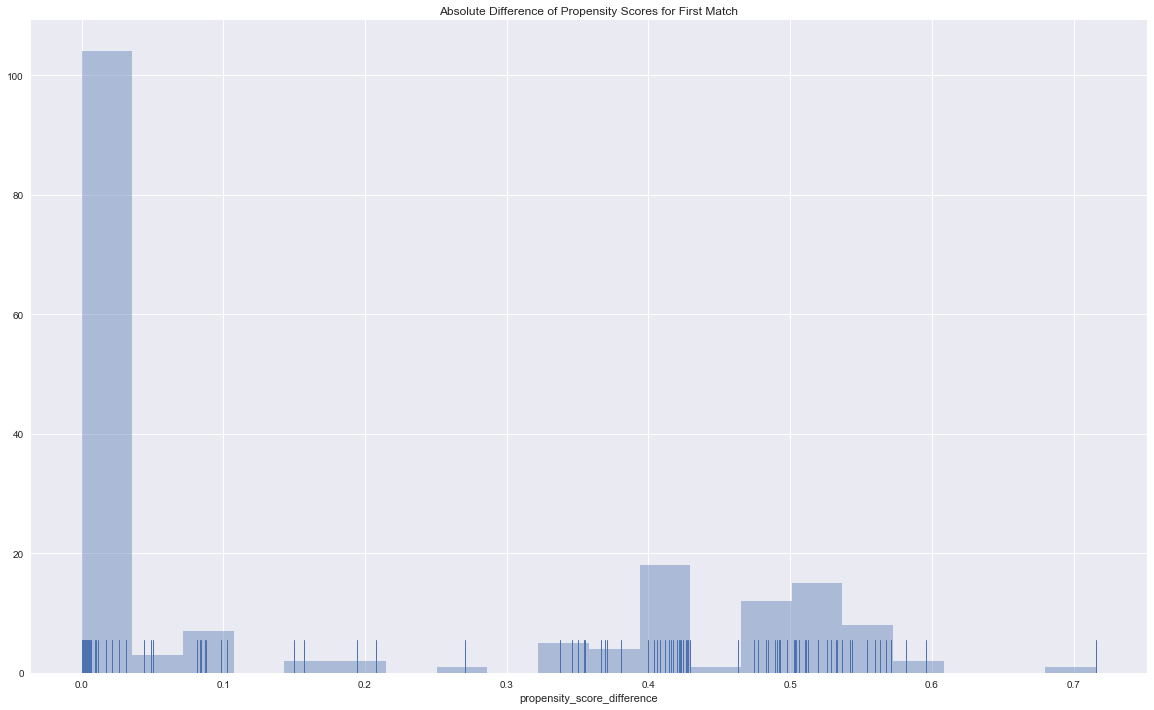

In [28]:
fig, axes = plt.subplots(1,1, figsize=(20, 12))
sns.distplot(df1['propensity_score_difference'], ax=axes, kde=False, rug=True, bins=20).set_title("Absolute Difference of Propensity Scores for First Match");

Construct treat_matched and control_matched dataframes containing people matched with each other beacuse of having a similar propensity score and in treat and control groups, respectively.

In [29]:
treat_matched = treat_w_score.copy()

In [30]:
control_matched = control_w_score.loc[df1["matched_index"]].copy()

### 4.2. Outcome "re78"

Check distribution of "re78" in control_matched and treat_matched groups using describe() functionality of pandas. It gives number of elements, mean, standard deviation, minimun and maximum value, median, 25% and 75% percentiles for given feature. Also examine distribution of "re78" in control group to see how it changed after matching.

In [31]:
control_matched["re78"].describe()

count      185.000000
mean      5828.584903
std       6094.306306
min          0.000000
25%        237.914000
50%       4112.513000
75%       8957.978000
max      25564.670000
Name: re78, dtype: float64

In [32]:
control["re78"].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [33]:
treat_matched["re78"].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

Check distribution of "re78" in control_matched and treat_matched groups using plots. For both treat and control groups separate histogram with rugs, kernel density estimator ans boxplot are plotted. For more clear comparison, unified and normalized histogram is also given. 

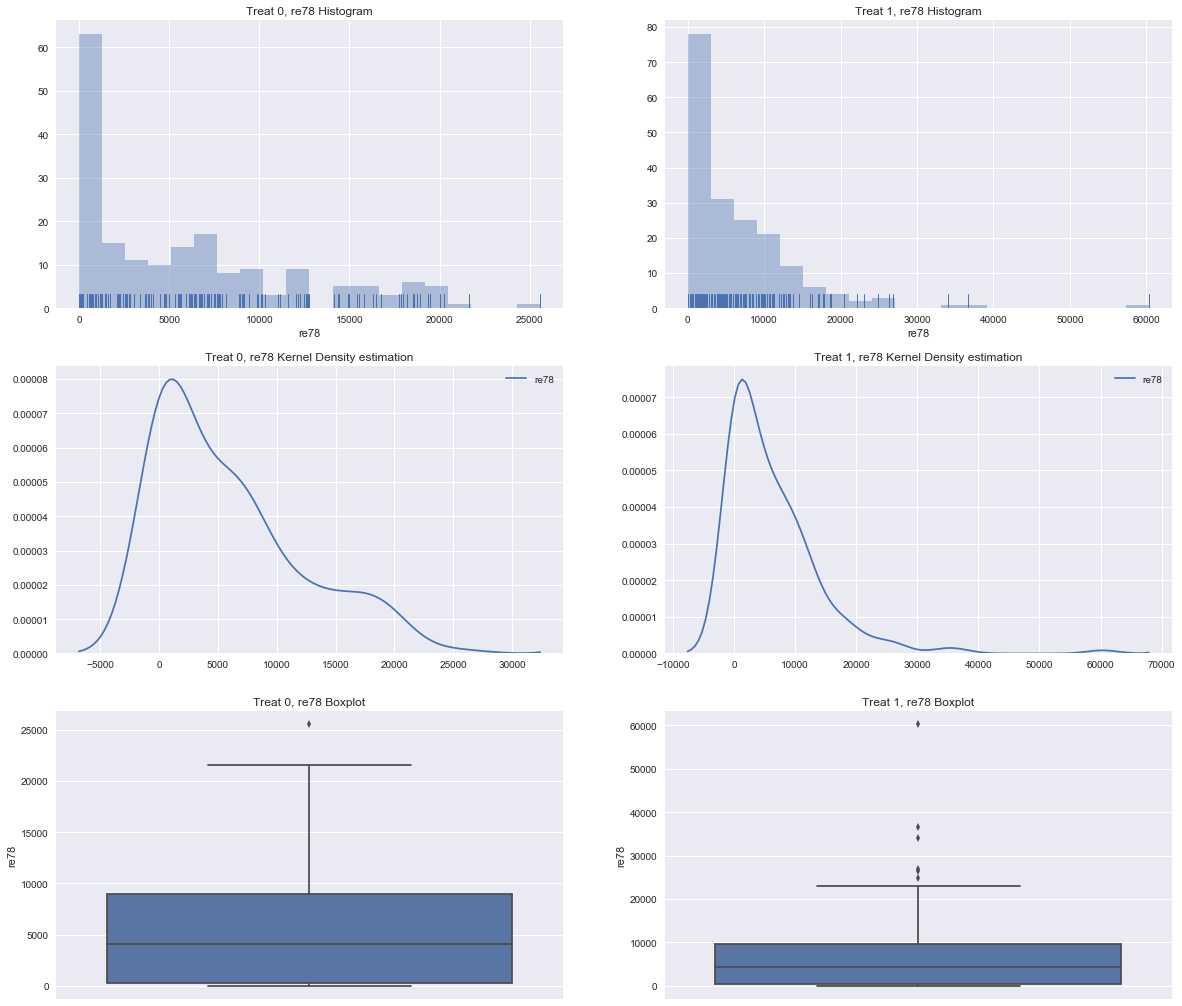

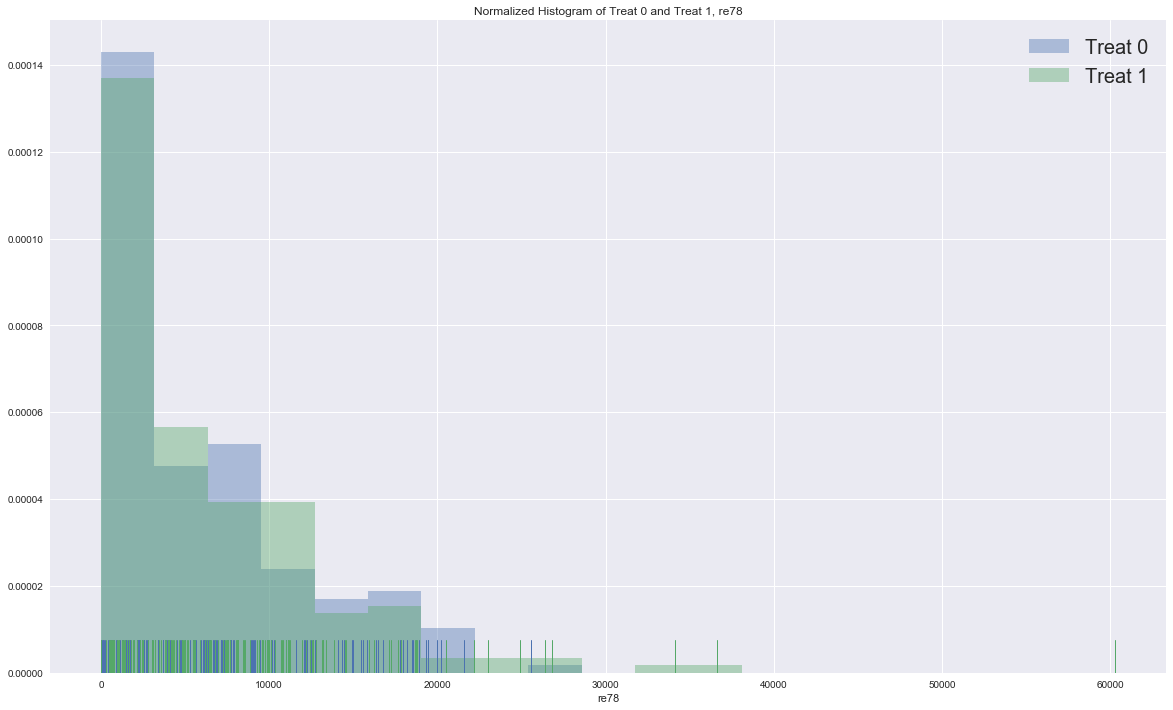

In [34]:
plot_numerical_features(control_matched, treat_matched, "re78")
plot_two_histograms(control_matched, treat_matched, "re78")

After matching, we will compare "re78" distribution in treat and control groups. In order to examine whether distribution of featres for control group get more similar to treat group after matching, we will also compare control group before and after matching.

Mean value of control_matched group is 5828 whereas for treat_matched group is 6349. Note that mean value for control group before matching was 6984, thus, being naive one could think that after treatment salaries got worse. So comparing the control group before and after treatment, it is clear that salaries seemed to be higher before as feature distributions were skewed. However, after matching we see that for treat_matched group salaries is almost 9% higher than control_matched group. Median of treat_matched (4232) is also higher than median of control_matched (4112), although the difference is very smaller. Indeed, examining the plot one can see that treat_matched group have more poeple in the right of the plot with higher salaries in 1978 and also fewer people without any salary. Looking at these results, one might argue that job training program is effective as treat_matched group has higher "r78" than control_matched. However, one should not act naively and must examine feature distributions before making such statements.

### 4.3. Features

Check distribution of features in control and treat groups using describe() functionality of pandas. It gives number of elements, mean, standard deviation, minimun and maximum value, median, 25% and 75% percentiles for given feature. Also examine distribution of features in control group to see how it changed after matching.

In [35]:
control_matched.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,185.0,185.000000,185.000000,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.0,23.167568,9.864865,0.47027,0.102703,0.183784,0.675676,2268.386180,1670.138671,5828.584903,0.377476
std,0.0,9.337805,2.775692,0.50047,0.304394,0.388359,0.469392,4266.737051,2734.930726,6094.306306,0.234568
min,0.0,16.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036219
25%,0.0,17.000000,8.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,237.914000,0.183745
50%,0.0,19.000000,10.000000,0.00000,0.000000,0.000000,1.000000,336.993900,470.854800,4112.513000,0.239343
75%,0.0,24.000000,12.000000,1.00000,0.000000,0.000000,1.000000,2217.890000,1976.516000,8957.978000,0.650508
max,0.0,55.000000,17.000000,1.00000,1.000000,1.000000,1.000000,21918.320000,13776.530000,25564.670000,0.792162


In [36]:
control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


In [37]:
treat_matched.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.555453
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218,0.206467
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036175
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.451977
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,0.647735
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,0.695839
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,0.885622


Check distribution of features in control_matched and treat_matched groups using plots. Different comparisons for categorical and numerical features are provided.

For categorical features, their ratios in the data are plotted in single boxplot for both treat and control groups.

For each numerical feature, separate histogram with rugs, kernel density estimator ans boxplot are plotted for both treat and control groups. For more clear comparison, unified and normalized histogram is also given.

#### 4.3.1. Categorical Features

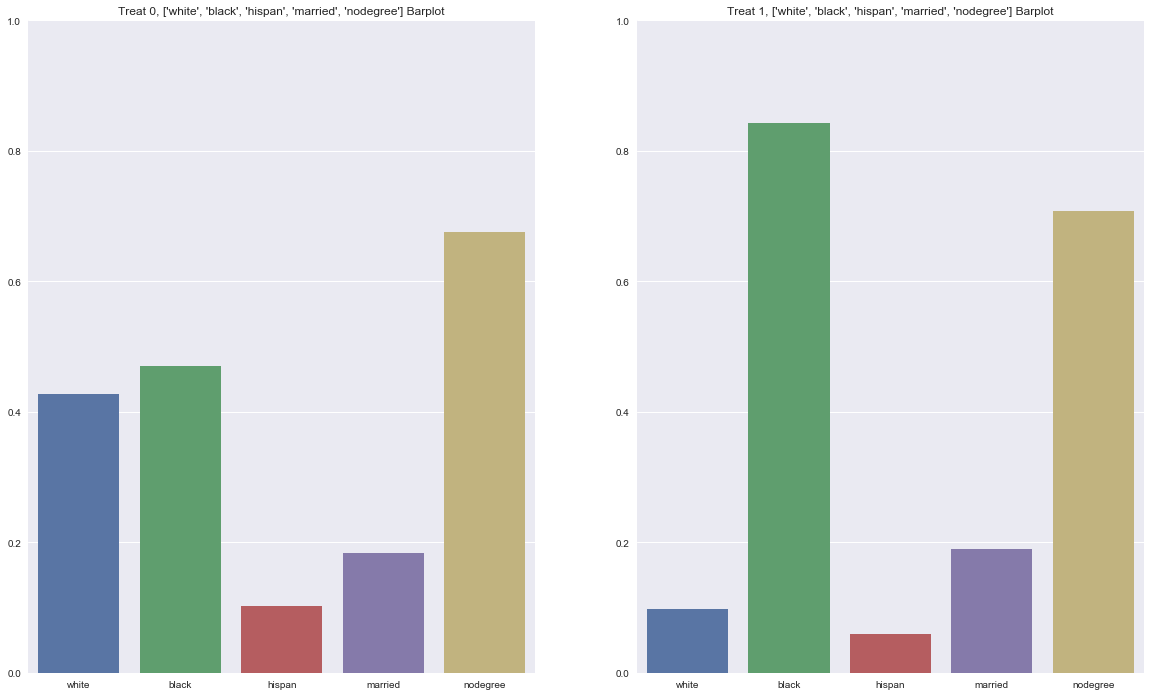

In [38]:
categorical_features = ["white", "black", "hispan", "married", "nodegree"]

plot_categorical_features(control_matched, treat_matched, categorical_features)

#### 4.3.2. Numerical Features

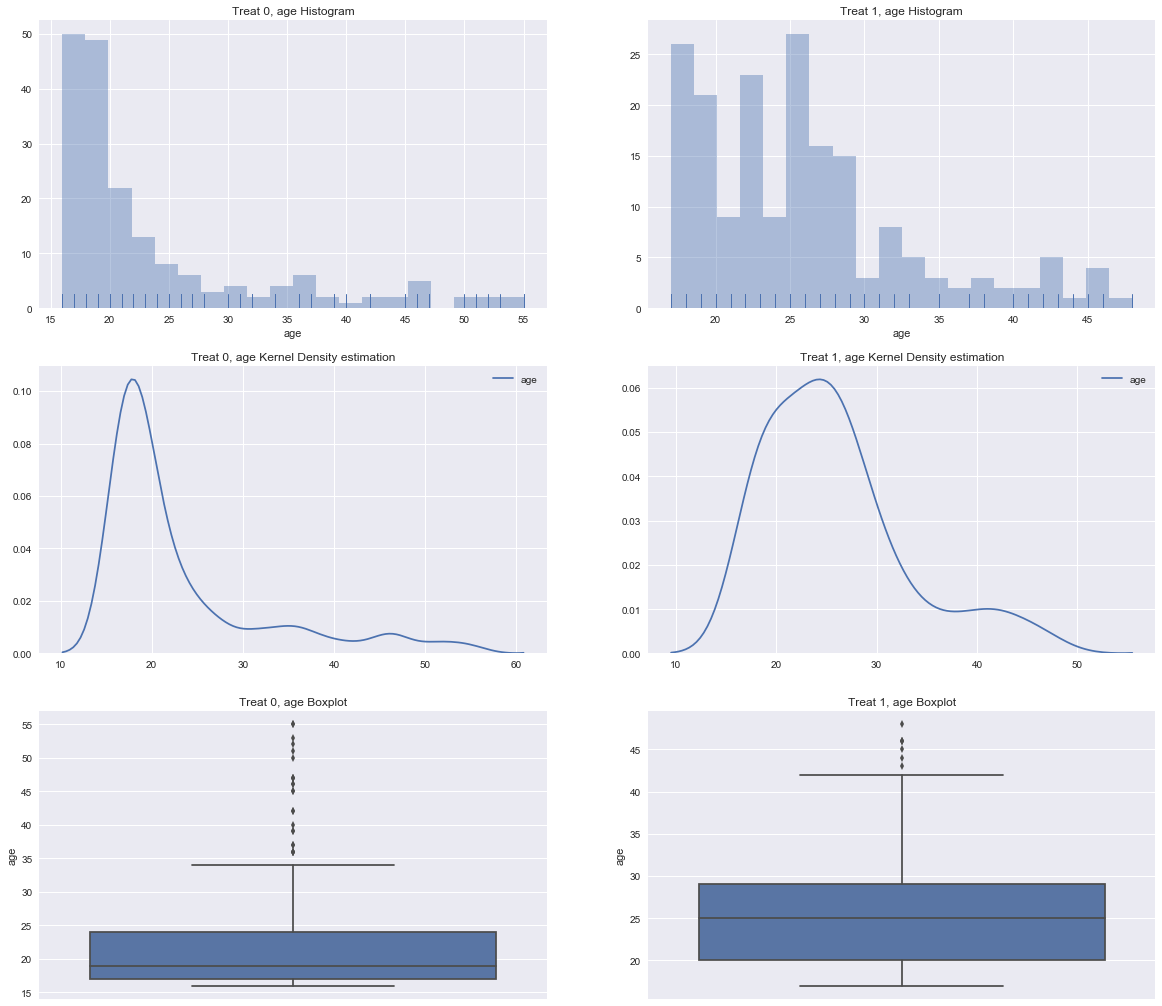

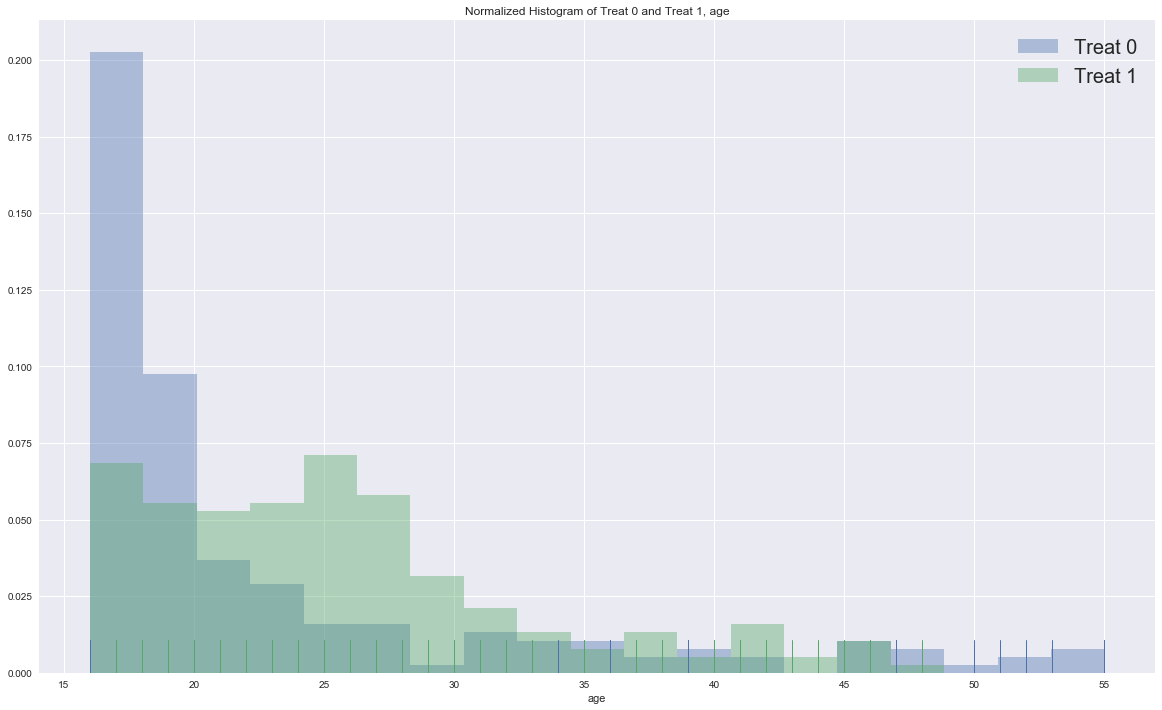

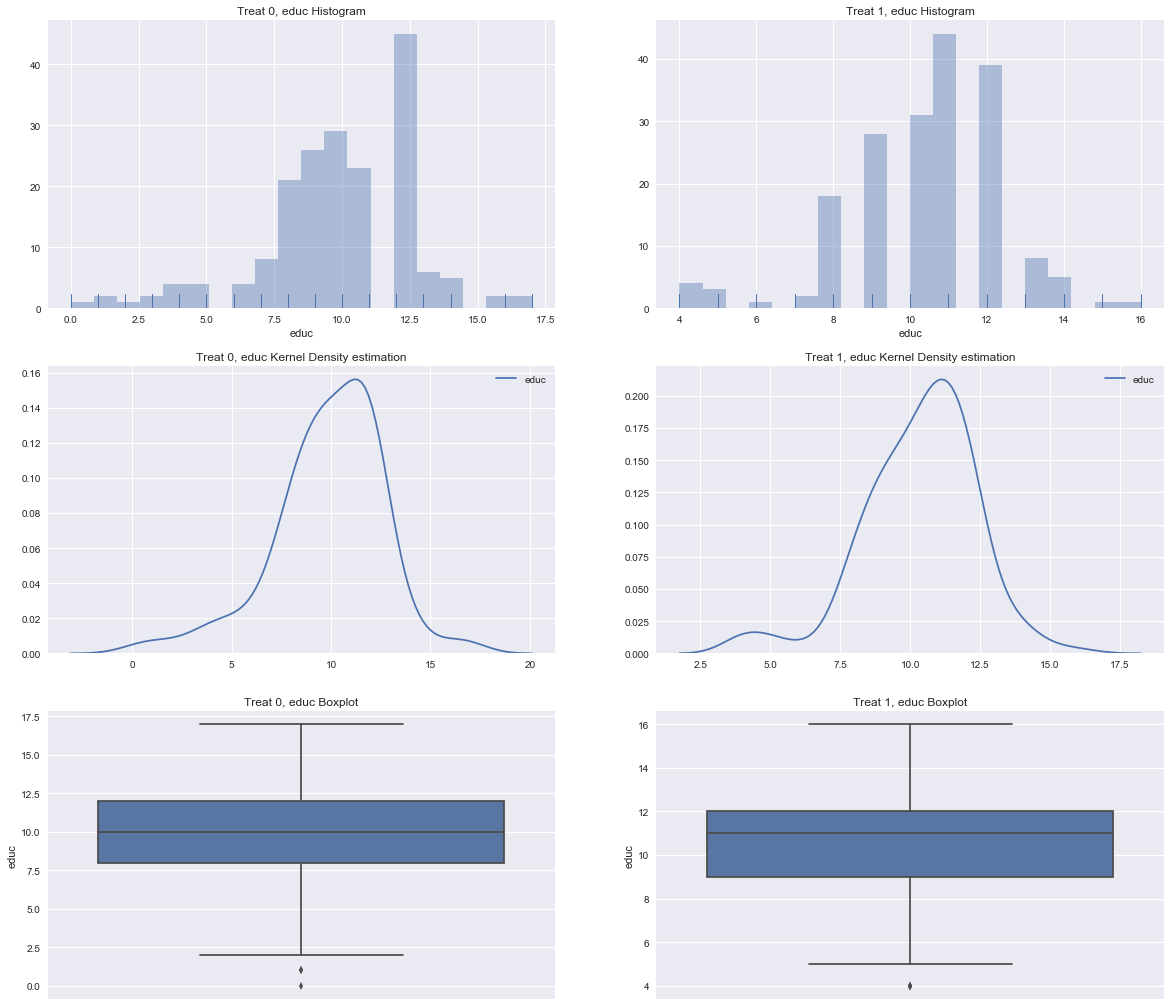

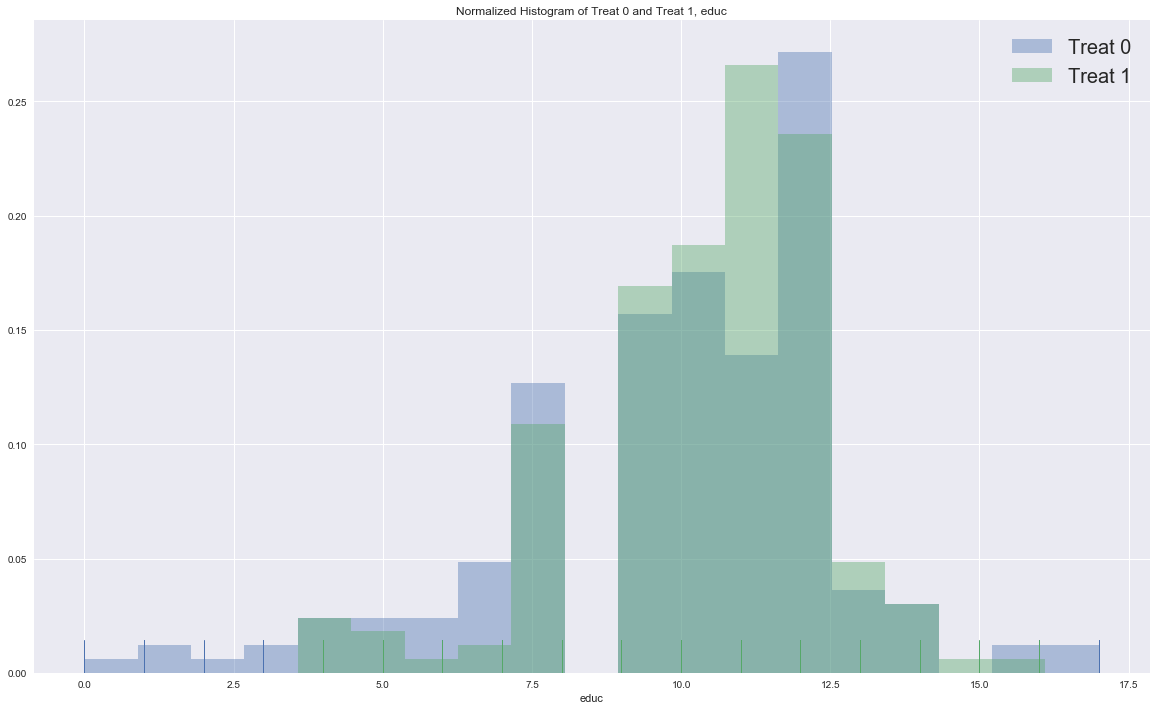

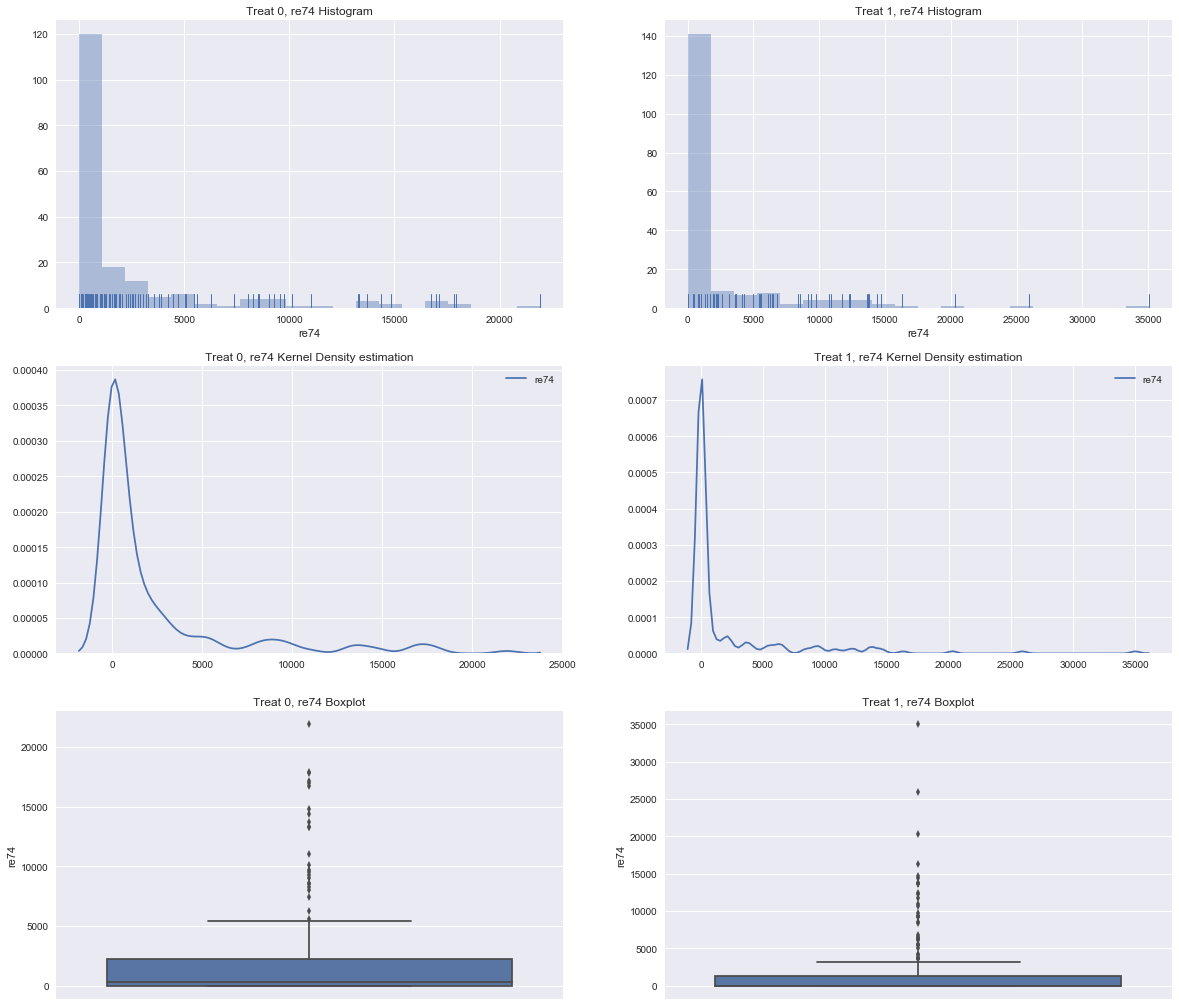

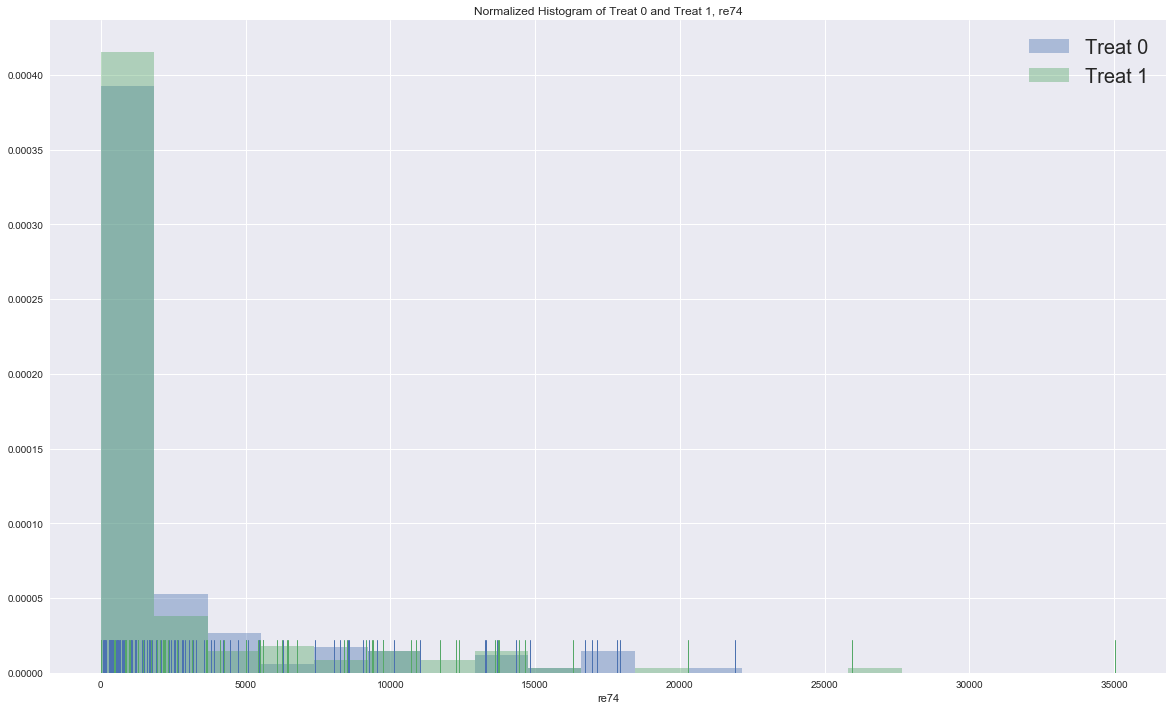

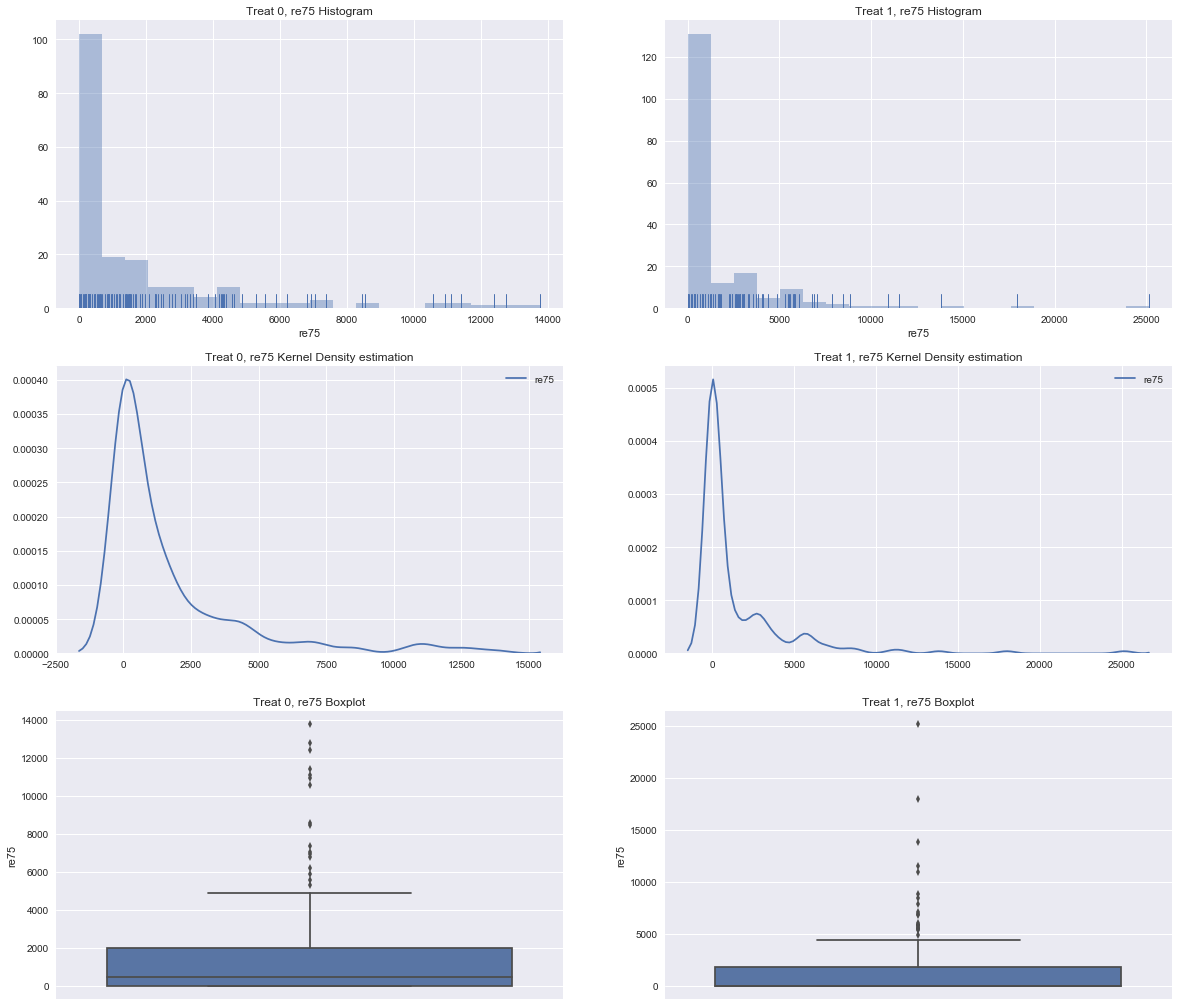

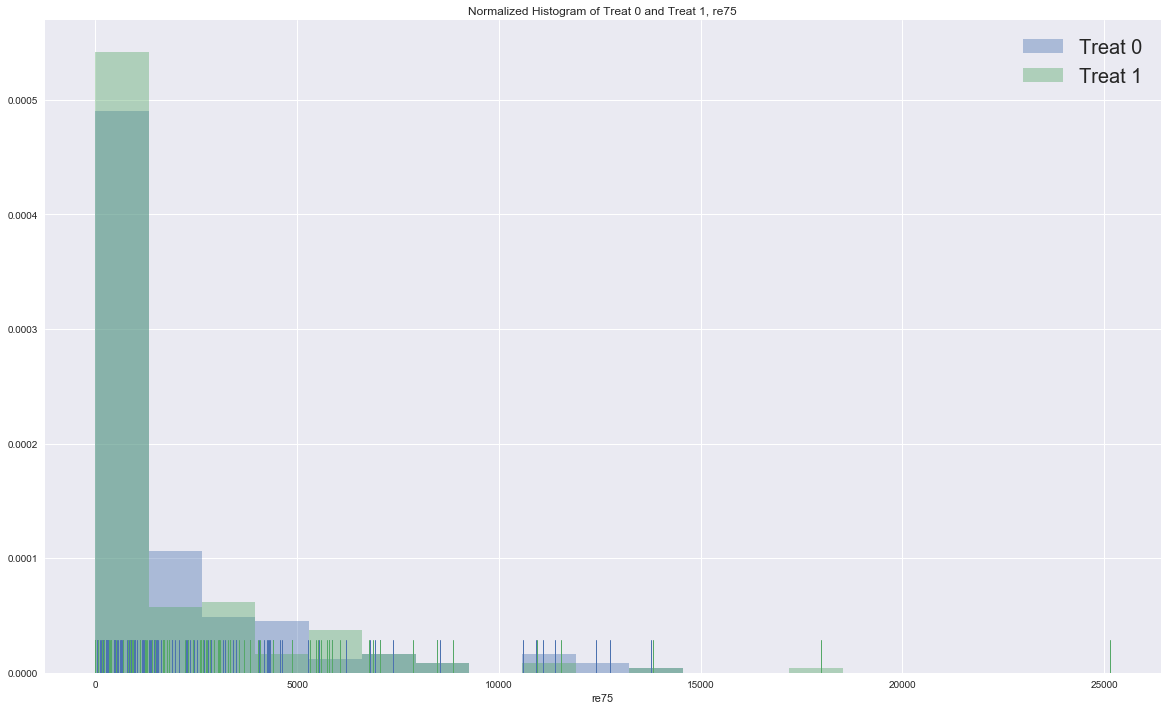

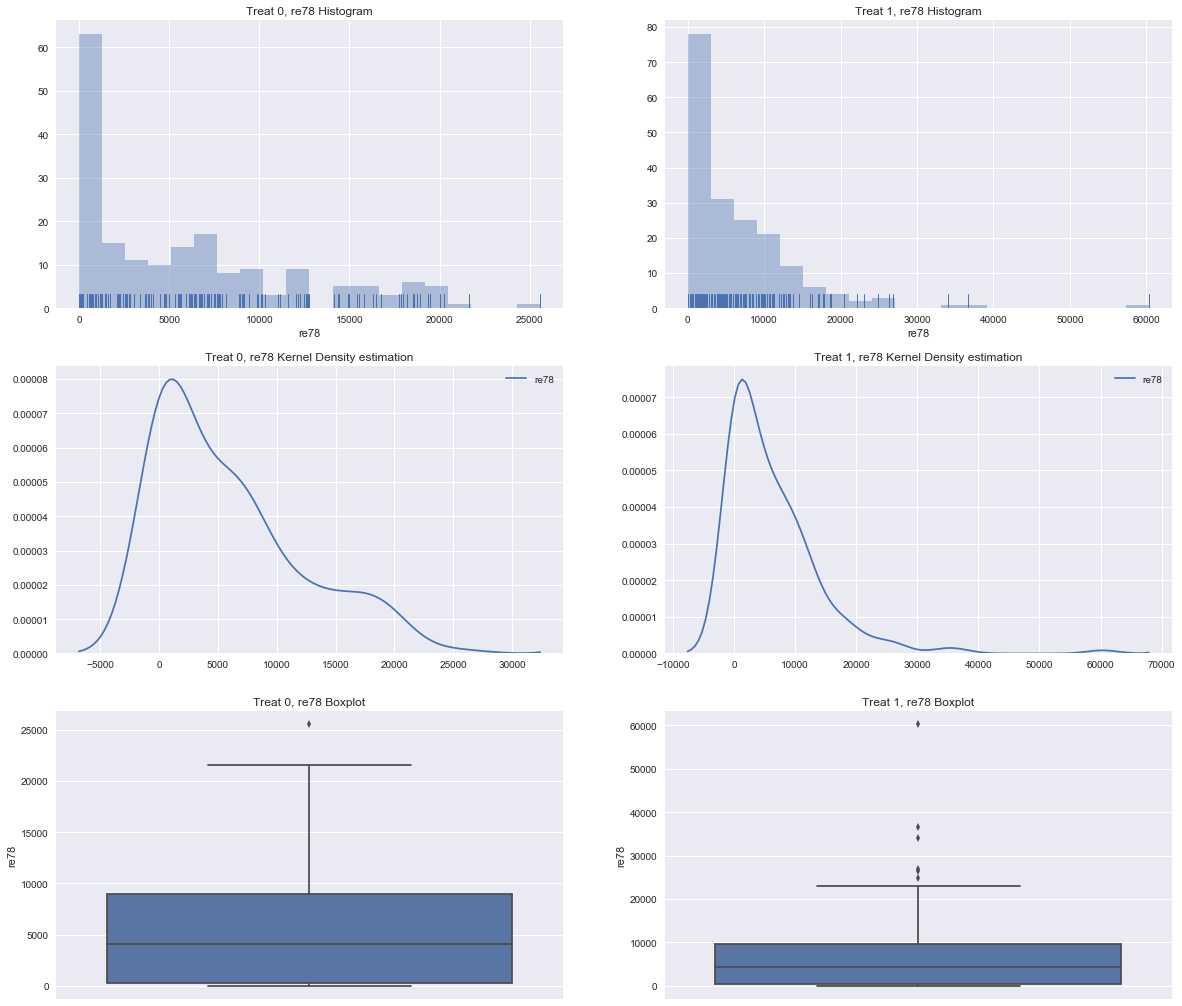

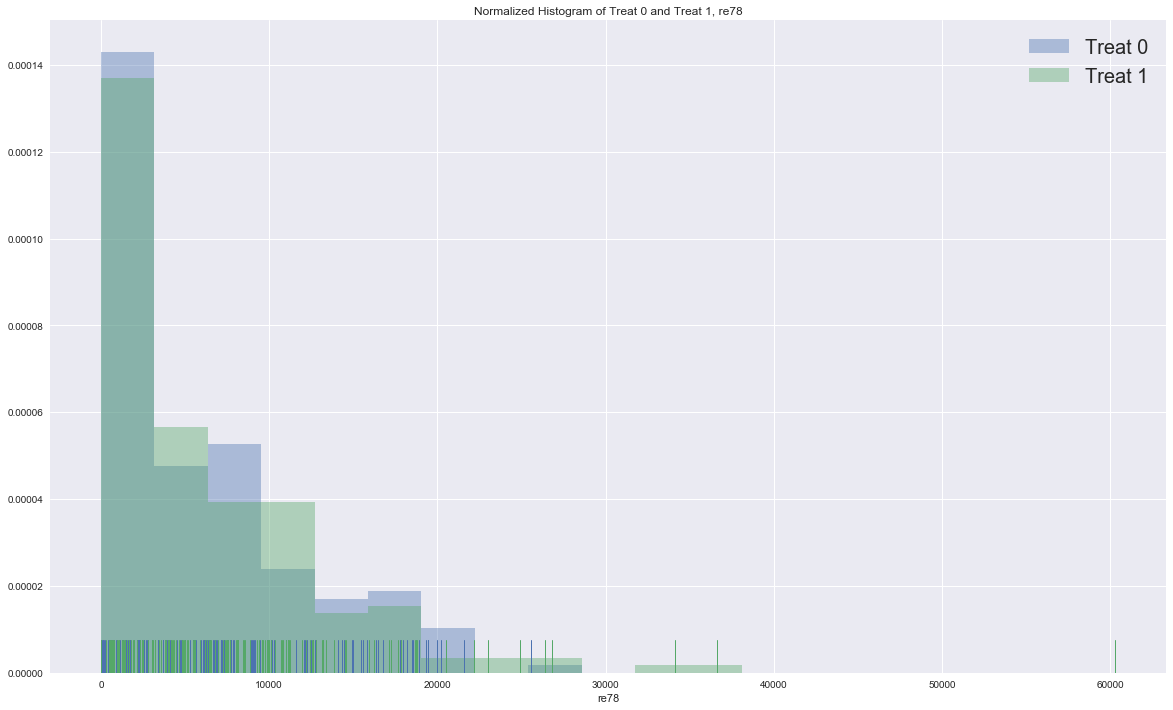

In [39]:
numerical_features = ["age", "educ", "re74", "re75", "re78"]

for col in numerical_features:
    plot_numerical_features(control_matched, treat_matched, col)
    plot_two_histograms(control_matched, treat_matched, col)

By looking at the numerical values and plots of the features, one can see that distribution of control_matched group is more similar to treat group than control group before matching, although the similarity is not perfect two of the features: age and black.

For age distribution means are again somewhat different, 23.16 for control_matched and 25.8 treat groups. Moreover, examining the plots, we see that for control_matched group the left and right of the plot are more populated which means that there are more young and more old people in control_matched group whereas ratio of mid age people is significantly higher in treat_matched group. Note that, there are very few old people in treat group whereas there are quite a few old people in control group. After matching, two distributions are more similar although not perfect, which means matching is helpful but do not solve the whole problem on its own. Summing all up, distribution of age feature is very different for treat_matched and contol_matched groups which should prevent naive researcher to make a conclusion about effectiveness of job training program by just examining outcome "re78".

For education distribution means are very similar, 9.86 for control_matched and 10.35 treat_matched groups. Moreover, examining the plots, we see that for control_matched group the left and right of the plot are more populated which means that there are more less educated and more very educated people in control_matched group whereas ratio of somewhat educated (around 10 years) people is significantly higher in treat_matched group, but these differences are smaller than before matching. Note that, in the both end of the histogram all people are from control_matched group which means that distribution of education feature is not exactly similar for treat_matched and contol_matched groups which means that naive researcher should be careful to make a conclusion about effectiveness of job training program by just examining outcome "re78".

For re74 distribution means are very similar, 2268 for control_matched and 2095 treat_matched groups. Note that before matching control group had a mean of 5620, which means matching helped a lot for making re74 distributions similar for treat_matched and control_matched groups. By looking at the histogram, we see that each group has lots of unemployed people (with salary 0) and number of unemployed people in both group are almost equal. Moreover, the distribution treat_matched group and control_matched group are very similar in general for re74, although maximum value for treat_matched is lot higher than control_matched. Intuitively, one would expect that person earning a lot in 1974 is more likely to earn a lot in 1978 which means that reaching a conclusion about job training program's effectiveness by just comparing salaries in 1978 without first making sure that other features are distributed similarly is prone to error. We see that after matching, distributions are now more similar so reaching a conclusion is more correct.

For re75 distribution means are very simiar, 1679 for control_matched and 1532 treat groups. Note that before matching control_matched group had a mean of 2466, which means matching helped a lot for making re75 distributions similar for treat_matched and control_matched groups. By looking at the histogram, we see that each group has lots of unemployed people (with salary 0) and number of unemployed people in both group are almost equal. Moreover, the distribution treat_matched group and control_matched group are very similar in general for re75, although maximum value for treat_matched is lot higher than control_matched. Intuitively, one would expect that person earning a lot in 1975 is more likely to earn a lot in 1978 which means that reaching a conclusion about job training program's effectiveness by just comparing salaries in 1978 without first making sure that other features are distributed similarly is prone to error.

For racial distribution, treat_matched and control_matched groups differ but they are more similar after matching. Ratio of races in two groups are as follows: 43% white, 47% black, 10% hispanic in control group and 10% white, 84% black and 6% hispanic in treat group. Note that, before matching control group had racial distribution of 66% white, 20% black, 14% hispanic which means matching helped a lot for making the distributions more similar but did not solve the problem. It is possible have a strong correlation between one's race and salary, which means that earnings in 1978 might be depending strongly on racial distribtion of two groups. As the sampling of the data is skewed in at least one of the features, one cannot reach a true conclusion on effectiveness of job training programs right away by just comparing numerical values and plots for salaries in 1978. Since the two ditsributions have very different percentages especially for black ratio, that feature might make the conclusion biased if researched is not careful.

For married distribution, 18.3% of control_matched group and 19% of treat_matched group is married. Before matching, control group had 51% married, which means matching helped a lot and in fact now two resulting distributions are almost equivalent. As being married might be correlated with high earning (for example, age is correlated with both. as age increases possiblity of being married and earning more is more likely.), one should make sure that maritial status of treat and control groups are distributed similarly before reaching a conclusing about the job training program's effectiveness. After matching we have almost exact distributions on married feature so reaching a conlusion about job training program is not prevented by that distribution. 

For nodegree distribution, 67.5% of control_matched group and 70% of treat_matched group have no degree. Before matching, control group had 60% nodegree, which means matching helped a lot and in fact now two resulting distributions are almost equivalent. Intuitively, as having a degree is positively correlated with having a higher income, it is hard to make a statement with unequal distributions. After matching we have almost exact distributions on nodegree feature so reaching a conlusion about job training program is not prevented by that distribution. 

As explained above matching helped a lot to make feature distributions more similar for treat_matched and control_matched groups. So we are closer to being able to draw valid conclusions now than we were before, although situation is still not perfect. There are two features which are still not distributed similarly. The first one is age and being a numerical feature it is very hard to constraint two groups to have the same distribution on age. The second one is black feature which can skew the results as one's racial background is highly correlated with her/his education, salary etc. especially in the US. If one can make sure that these two features are distributed more similarly for treat and control groups, then he/she will be closer to make a conclusion out of outcome. For this purpose, in the next question we will constring black feature distributions to be exact for treat and control groups.

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


**How to balance two groups further**

In the previous question, we see that matching helps a lot to balance feature distributions of two groups, treat and control. However, age and black features are still far off for two groups. It is hard to constraint age feature to be distributed similarly for treat and control groups so we will make sure that black ratios in both groups are the same. The reasons behind the choice of black feature are following:

* Black feature distribution in treat_matched and control_matched groups are far off

* Being a binary feature, it is very to ease to constrint that black distributions are the same

* Intuitively speaking, being black might be higly correlated with one's salary, especially in the US.

In order to make sure that black distributions are the same, we will split both treat and control groups into two, one consisting only black people and other consisting only non-black people. Then, we will match blakc people in treat group with black people in control group in a similar fashion as in the question 4. The same procedure will be applied for non-black people in treat and control groups as well. Note that, we will still match each data point from the treated group with exactly one data point from the control group if possible (for example, number of black peope in treat group is much higher than in control group so matching each black people in treat group with a black people from control group is not possible as long as any individual in control group is matched with at most one individual from treat group), while ensuring that each data point from the control group is matched with at most one data point from the treated group.

**Steps**

1) Divide data with propensity scores into two dataframes for both treat_w_score and control_w_score according to "black" feature, resulting 4 different dataframes: treat_w_score_black, control_w_score_black, treat_w_score_other, control_w_score_other.

2) Use match function given below to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group using propensity scores. Matching is done such that black person in treat group is matched with a black person in control group and non-black person in treat group is matched with a non-black person in control group, thus making sure that each treat and control group have the same number of black people after matching.

3) Construct treat_matched_2 and control_matched_2 dataframes containing people matched with each other beacuse of having a similar propensity score, being black or non-black and being in treat and control groups, respectively.

4) Check distribution of "re78" in control_matched_2 and treat_matched_2 groups using describe() functionality of pandas.

5) Check distribution of "re78" in control_matched_2 and treat_matched_2 groups using plot_numerical_features and plot_two_histograms functions given above.

6) Check distribution of features in control_matched_2 and treat_matched_2 groups using describe() functionality of pandas.

7) Check distribution of features in control_matched_2 and treat_matched_2 groups using plot_numerical_features and plot_two_histograms functions given above.

8) Make comments about the results.

### 5.1. Matching

Divide data with propensity scores into two dataframes for both treat_w_score and control_w_score according to "black" feature, resulting 4 different dataframes: treat_w_score_black, control_w_score_black, treat_w_score_other, control_w_score_other. Use match function given below to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group using propensity scores. Matching is done such that black person in treat group is matched with a black person in control group and non-black person in treat group is matched with a non-black person in control group, thus making sure that each treat and control group have the same number of black people after matching.

In [40]:
# divide dataset as black, other for treat and control
treat_w_score_black = treat_w_score[treat_w_score["black"]==1]
control_w_score_black = control_w_score[control_w_score["black"]==1]
treat_w_score_other = treat_w_score[treat_w_score["black"]==0]
control_w_score_other = control_w_score[control_w_score["black"]==0]

# match black treat with black control, other treat with other control
df1_black, df2_black = match(treat_w_score_black, control_w_score_black)
df1_other, df2_other = match(treat_w_score_other, control_w_score_other)

# concatenate
df1_together = pd.concat([df1_black, df1_other])
df2_together = pd.concat([df2_black, df2_other])

Check that "matched_index" column of df1_together, which stores the id of individual in control group which is matched with the individual in the treat group, has unique elements except the dummy index 0 denoting that that individual is not matched with anyone in the control group. It means that, data point from the control group is matched with at most one data point from the treated group. Note that, as number of black people in control group is lot less in control group than in treat group, there are black individuals in treat group which are not matched with anyone, thus, are excluded from the analysis below. In fact, after examining propensity scores, one can see that because of these individuals propensity score is very high for some of the matches in the question above.

In [41]:
print("There are {} black and {} non-black individuals in treat group".format(treat_w_score_black.shape[0], treat_w_score_other.shape[0]))
print("There are {} black and {} non-black individuals in control group".format(control_w_score_black.shape[0], control_w_score_other.shape[0]))
print("Are matched indexes unique?, {}".format(df1_together[df1_together["matched_index"]!=0].matched_index.is_unique))

There are 156 black and 29 non-black individuals in treat group
There are 87 black and 342 non-black individuals in control group
Are matched indexes unique?, True


Examine distribution of propensity scores for the second match. We see that indeed there are just few matches with somewhat high absolute difference for propensity scores between matched individuals. For example, the mean is down to 0.0125 from almost 0.18 and the max is down to 0.157 from almost 0.75. These give the idea that, the second match is better than the first one, thus,  this time feature distributions of the two matched groups are more similar. As the propensity scores are closer to each other, we conclude that matching in this question is better than provious control treat splits. Thus, this time we will nor compare for example control_matched with control_matched_2. After making sure that feature distributions are similar enough, one can argue that the effect on "re78" is caused only by "treat".

In [42]:
df1_together.loc[df1_together["matched_index"]!=0, 'propensity_score_difference'].describe()

count    116.000000
mean       0.012509
std        0.029726
min        0.000000
25%        0.000296
50%        0.000829
75%        0.005001
max        0.157090
Name: propensity_score_difference, dtype: float64

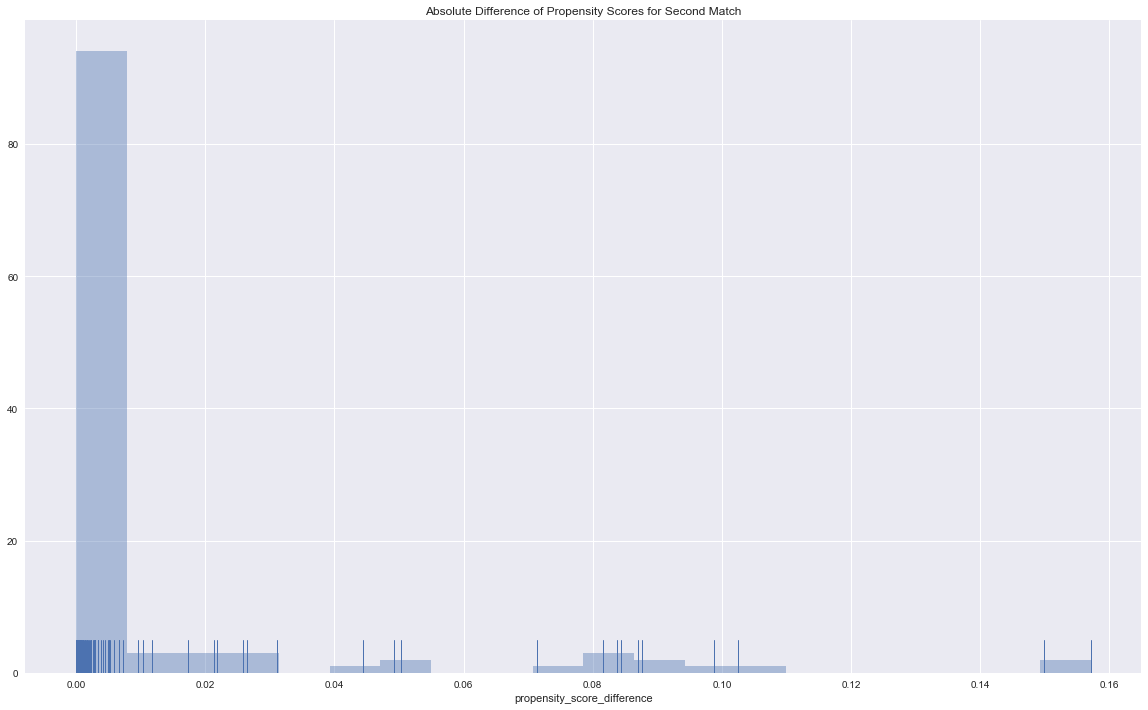

In [43]:
fig, axes = plt.subplots(1,1, figsize=(20, 12))
sns.distplot(df1_together.loc[df1_together["matched_index"]!=0, 'propensity_score_difference'], ax=axes, kde=False, rug=True, bins=20).set_title("Absolute Difference of Propensity Scores for Second Match");

Construct treat_matched_2 and control_matched_2 dataframes containing people matched with each other beacuse of having a similar propensity score, being black or non-black and being in treat and control groups, respectively. Examine resulting dataframes by head().

In [44]:
treat_matched_2 = treat_w_score[df1_together["matched_index"]!=0].copy()
control_matched_2 = control_w_score.loc[df1_together[df1_together["matched_index"]!=0].matched_index].copy()

C:\Users\furkan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [45]:
treat_matched_2.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.458074
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.151980
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.750966
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.670590
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0.711254


In [46]:
control_matched_2.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
230,PSID46,0,20,12,1,0,1,0,9555.3440,7055.6610,0.00000,0.376549
363,PSID179,0,18,11,1,0,0,1,2068.9860,1623.8230,20243.38000,0.751788
461,PSID277,0,19,10,1,0,0,1,1056.0450,205.8871,0.00000,0.668007
450,PSID266,0,17,9,1,0,0,1,0.0000,297.1935,54.67588,0.711295
536,PSID352,0,24,12,1,0,0,0,566.2281,0.0000,2284.56500,0.649079


### 5.2. Outcome "re78"

Check distribution of "re78" in control_matched_2 and treat_matched_2 groups using describe() functionality of pandas. It gives number of elements, mean, standard deviation, minimun and maximum value, median, 25% and 75% percentiles for given feature. Also examine distribution of "re78" in control, control_matched, treat and treat_matched groups to see how it changed after trying to balance the matched groups in terms of features.

In [47]:
control_matched_2["re78"].describe()

count      116.000000
mean      5541.079675
std       6498.524197
min          0.000000
25%          0.000000
50%       2742.660500
75%       8942.092750
max      25564.670000
Name: re78, dtype: float64

In [48]:
control_matched["re78"].describe()

count      185.000000
mean      5828.584903
std       6094.306306
min          0.000000
25%        237.914000
50%       4112.513000
75%       8957.978000
max      25564.670000
Name: re78, dtype: float64

In [49]:
control["re78"].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [50]:
treat_matched_2["re78"].describe()

count      116.000000
mean      6926.659090
std       7588.465182
min          0.000000
25%        666.459125
50%       4892.512500
75%      10846.230000
max      36646.950000
Name: re78, dtype: float64

In [51]:
treat_matched["re78"].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [52]:
treat["re78"].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

Check distribution of "re78" in control_matched_2 and treat_matched_2 groups using plots. For both treat and control groups separate histogram with rugs, kernel density estimator ans boxplot are plotted. For more clear comparison, unified and normalized histogram is also given.

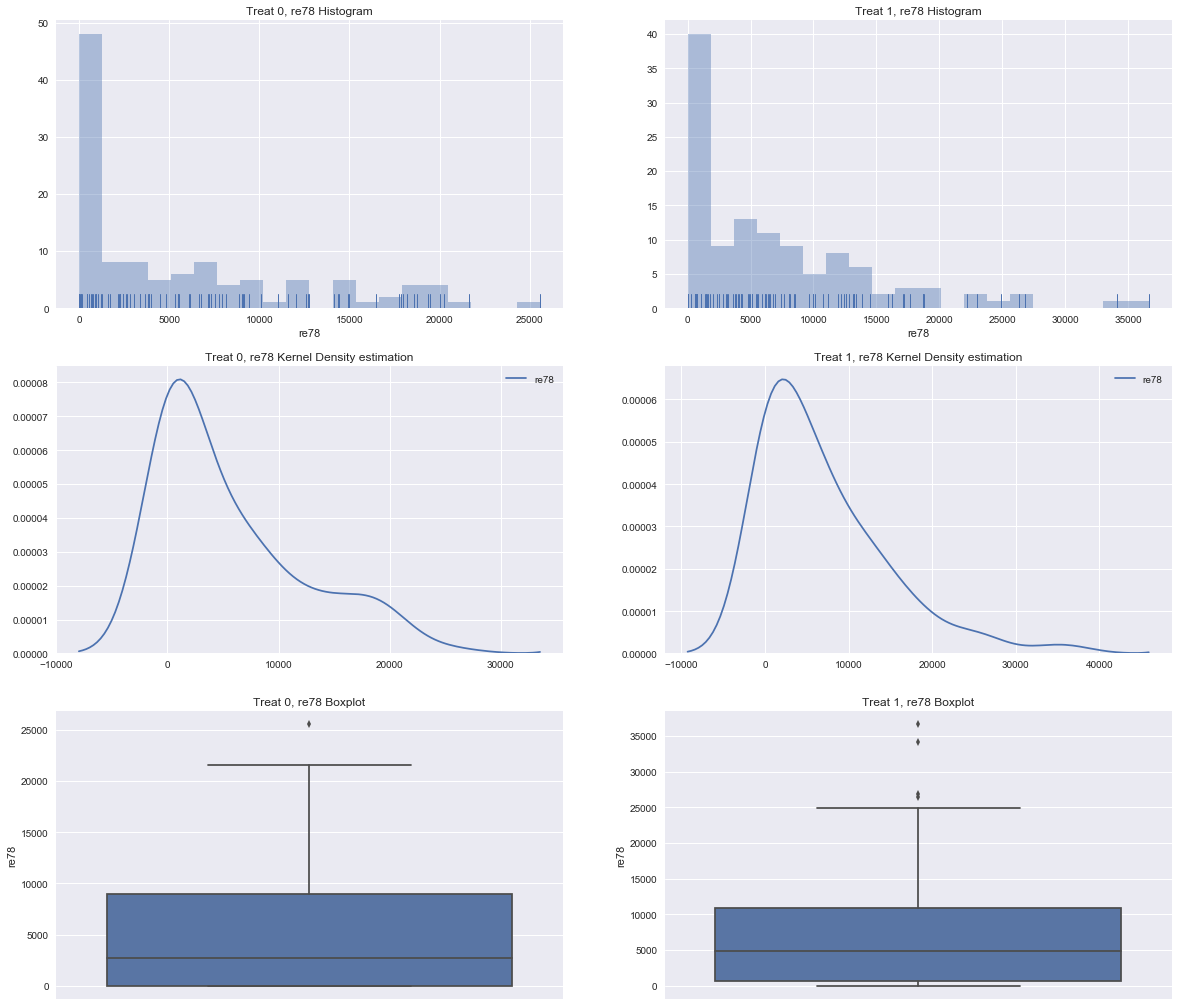

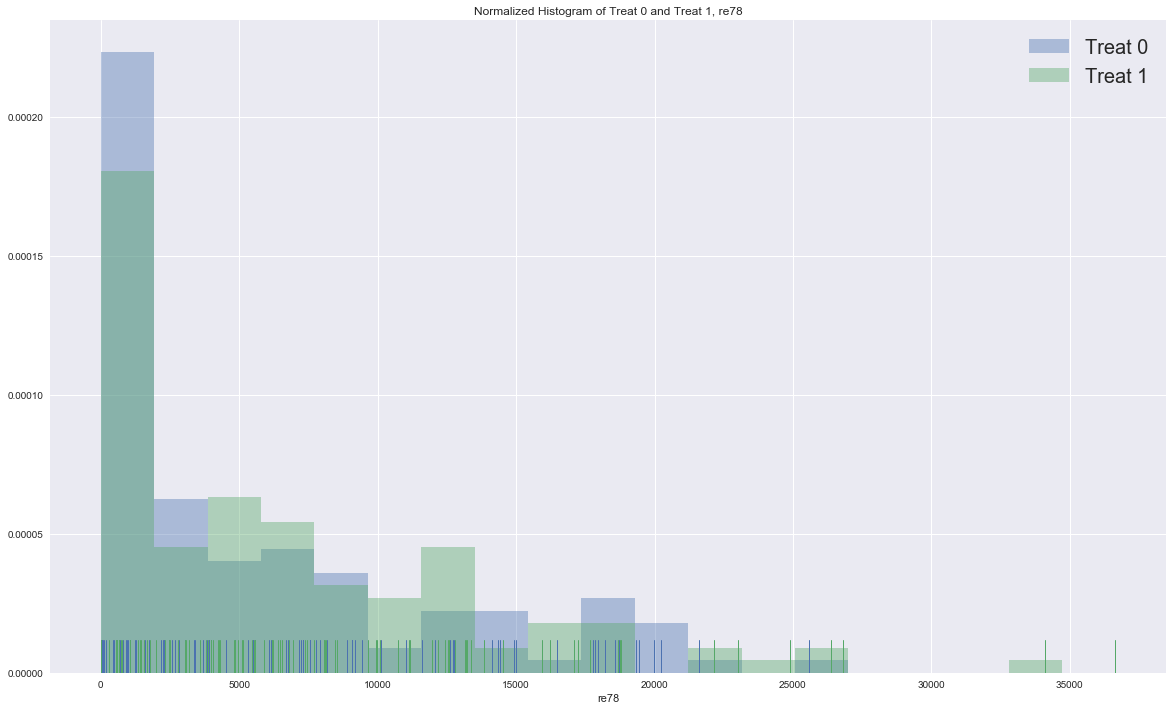

In [53]:
plot_numerical_features(control_matched_2, treat_matched_2, "re78")
plot_two_histograms(control_matched_2, treat_matched_2, "re78")

Discussions for this section are given in the question 6.

### 5.3. Features

Check distribution of features in control_matched_2 and treat_matched_2 groups using describe() functionality of pandas. It gives number of elements, mean, standard deviation, minimun and maximum value, median, 25% and 75% percentiles for given feature. Also examine distribution of features in control, control_matched, treat and treat_matched groups to see how it changed after trying to balance the matched groups in terms of features.

In [54]:
treat_matched_2.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,1.0,26.275862,10.267241,0.750000,0.094828,0.258621,0.689655,2443.800032,1560.813918,6926.659090,0.493872
std,0.0,7.635827,2.078284,0.434891,0.294248,0.439776,0.464642,5698.799908,3119.764981,7588.465182,0.234579
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036175
25%,1.0,21.000000,9.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,666.459125,0.263623
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4892.512500,0.569360
75%,1.0,29.000000,12.000000,1.000000,0.000000,1.000000,1.000000,1064.817850,1739.183500,10846.230000,0.694983
max,1.0,48.000000,14.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,17976.150000,36646.950000,0.801630


In [55]:
treat_matched.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.555453
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218,0.206467
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036175
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.451977
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,0.647735
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,0.695839
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,0.885622


In [56]:
treat.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [57]:
control_matched_2.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.00000,116.000000,116.000000,116.000000,116.000000
mean,0.0,25.456897,10.120690,0.750000,0.051724,0.267241,0.62069,3212.217984,1909.502418,5541.079675,0.485257
std,0.0,10.590720,2.693487,0.434891,0.222430,0.444439,0.48732,5105.935786,3142.677026,6498.524197,0.237087
min,0.0,16.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.036219
25%,0.0,18.000000,9.000000,0.750000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.253114
50%,0.0,20.000000,11.000000,1.000000,0.000000,0.000000,1.00000,607.372700,310.620950,2742.660500,0.557914
75%,0.0,30.250000,12.000000,1.000000,0.000000,1.000000,1.00000,4537.172000,2284.899500,8942.092750,0.695518
max,0.0,55.000000,17.000000,1.000000,1.000000,1.000000,1.00000,21918.320000,13776.530000,25564.670000,0.792162


In [58]:
control_matched.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
count,185.0,185.000000,185.000000,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.0,23.167568,9.864865,0.47027,0.102703,0.183784,0.675676,2268.386180,1670.138671,5828.584903,0.377476
std,0.0,9.337805,2.775692,0.50047,0.304394,0.388359,0.469392,4266.737051,2734.930726,6094.306306,0.234568
min,0.0,16.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036219
25%,0.0,17.000000,8.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,237.914000,0.183745
50%,0.0,19.000000,10.000000,0.00000,0.000000,0.000000,1.000000,336.993900,470.854800,4112.513000,0.239343
75%,0.0,24.000000,12.000000,1.00000,0.000000,0.000000,1.000000,2217.890000,1976.516000,8957.978000,0.650508
max,0.0,55.000000,17.000000,1.00000,1.000000,1.000000,1.000000,21918.320000,13776.530000,25564.670000,0.792162


In [59]:
control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


From above, one can argue that the second matching is better than the first matching and the first matching is better than no matching; which helps for drawing a conclusion using treat and control groups about effect of treatment on salaries in 1978.

Check distribution of features in control_matched_2 and treat_matched_2 groups using plots. Different comparisons for categorical and numerical features are provided.

For categorical features, their ratios in the data are plotted in single boxplot for both treat and control groups.

For each numerical feature, separate histogram with rugs, kernel density estimator ans boxplot are plotted for both treat and control groups. For more clear comparison, unified and normalized histogram is also given.

#### 5.3.1. Categorical Features

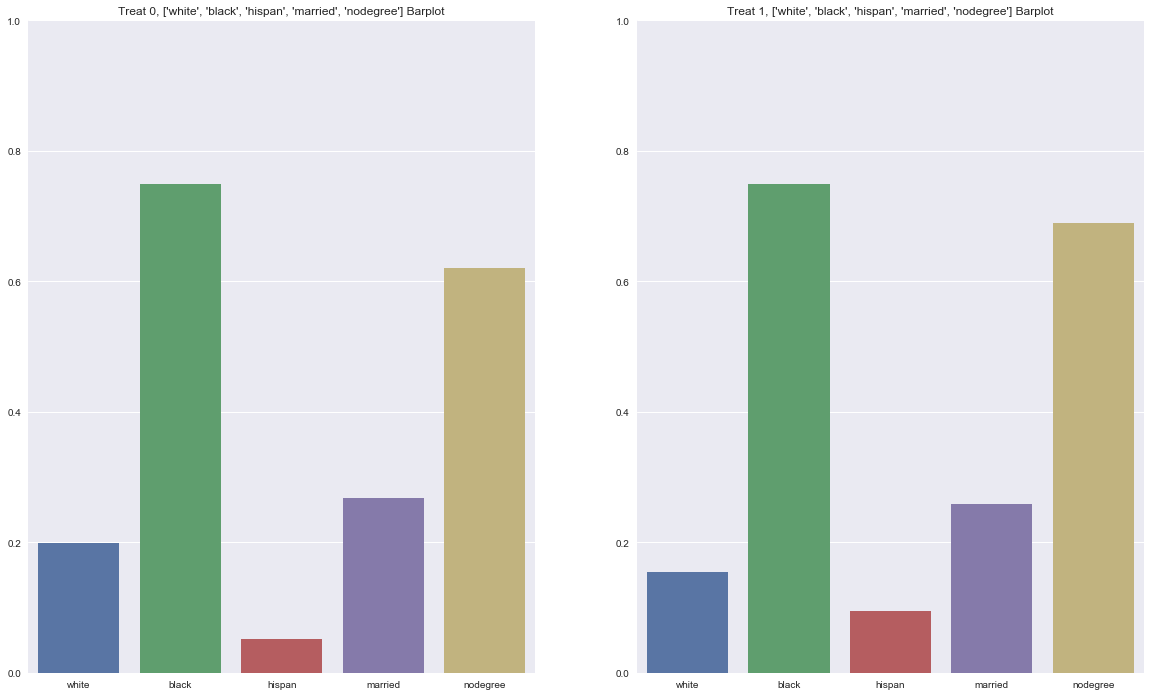

In [60]:
categorical_features = ["white", "black", "hispan", "married", "nodegree"]

plot_categorical_features(control_matched_2, treat_matched_2, categorical_features)

#### 5.3.2. Numerical Features

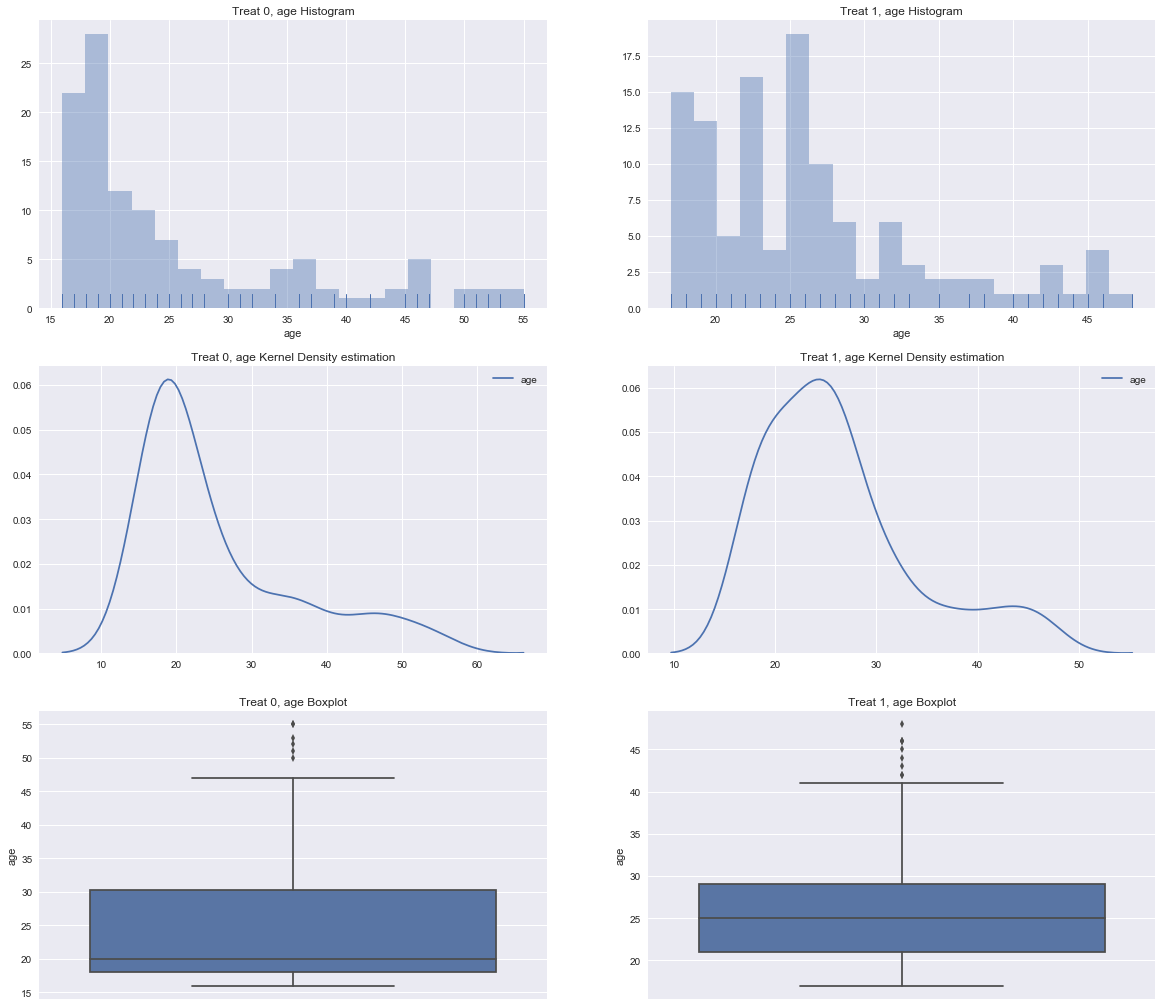

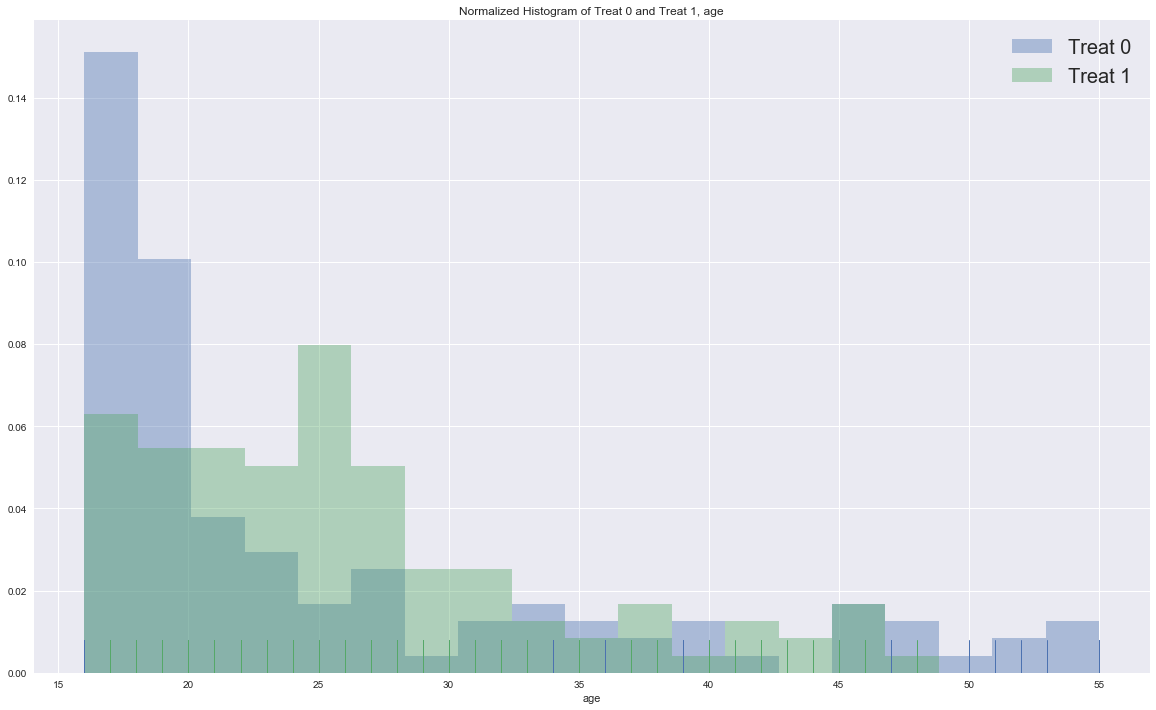

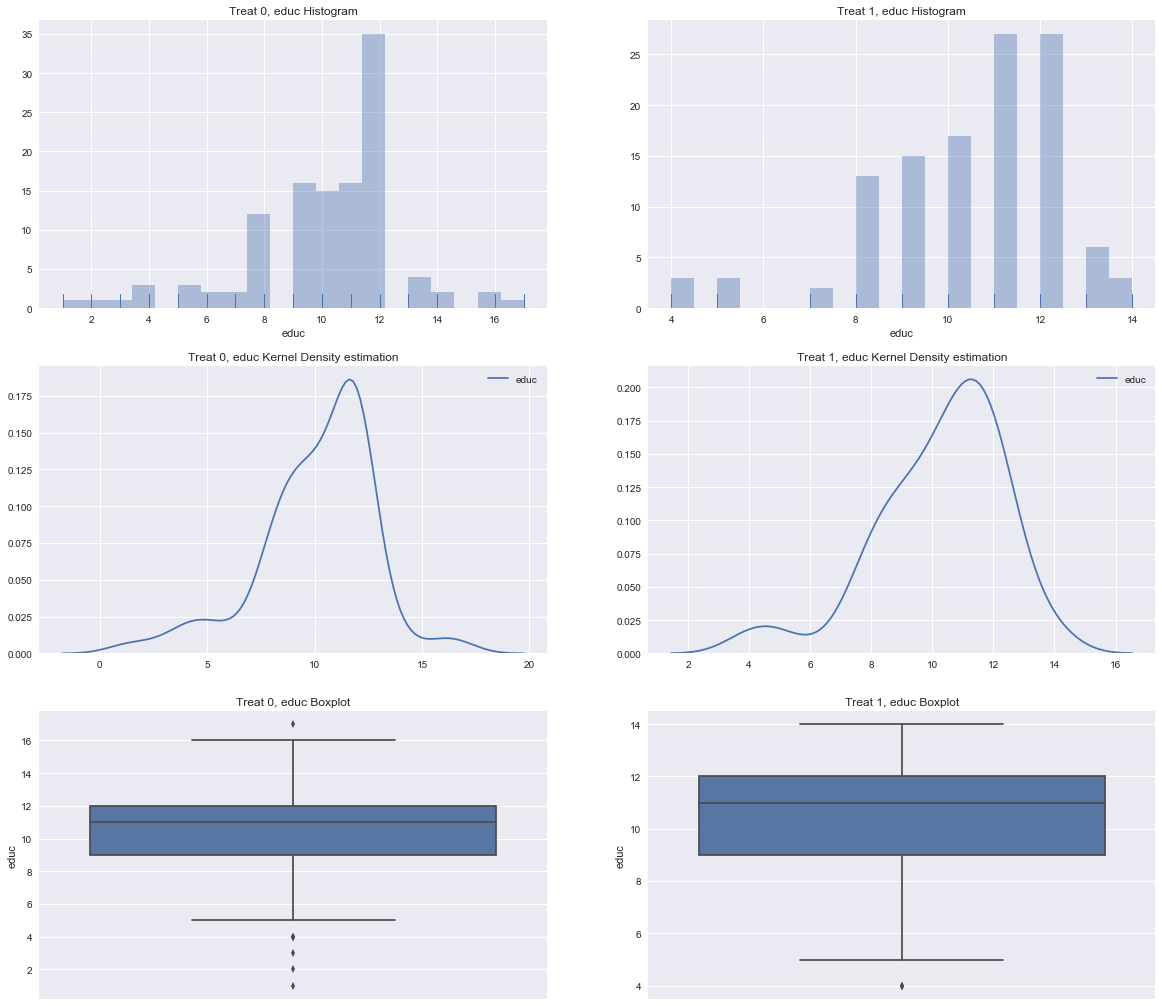

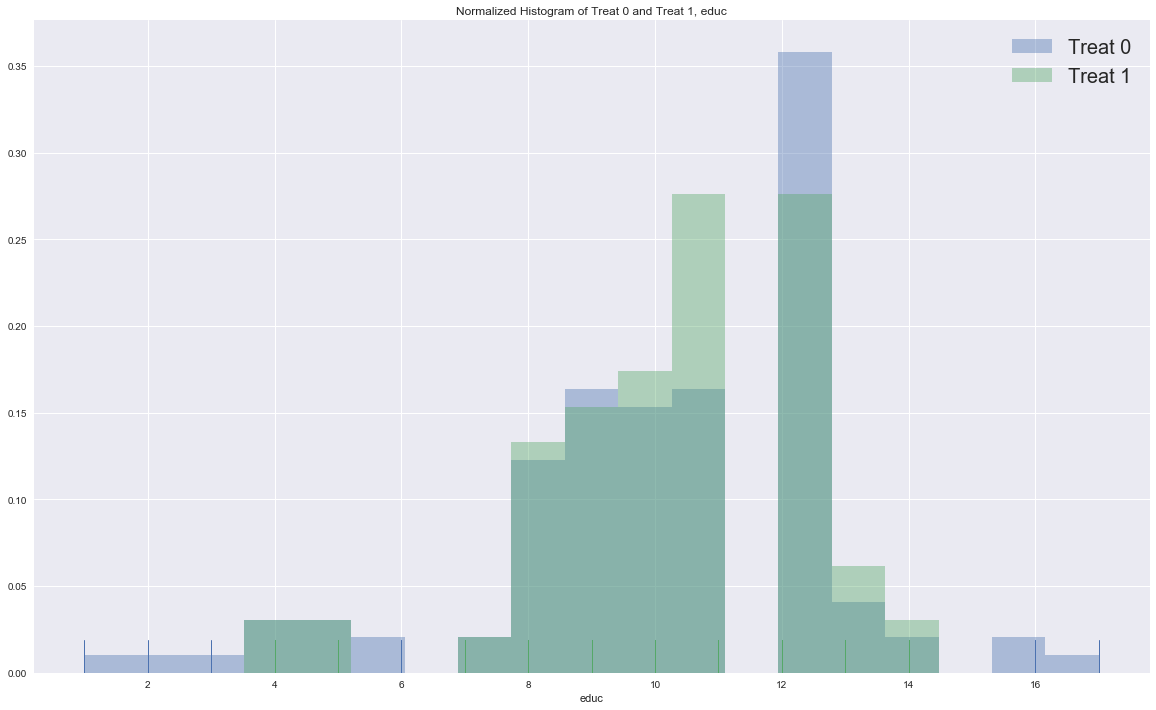

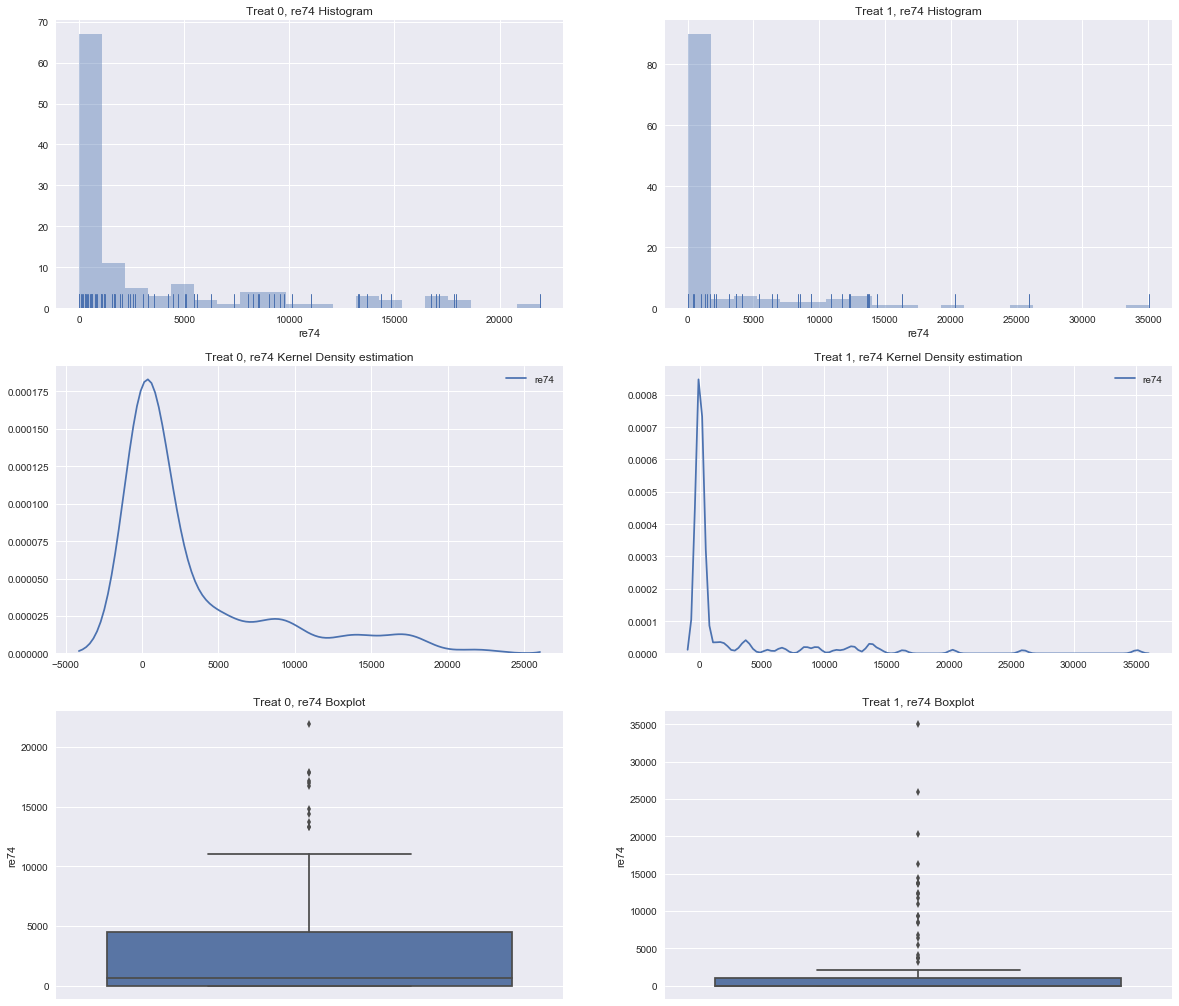

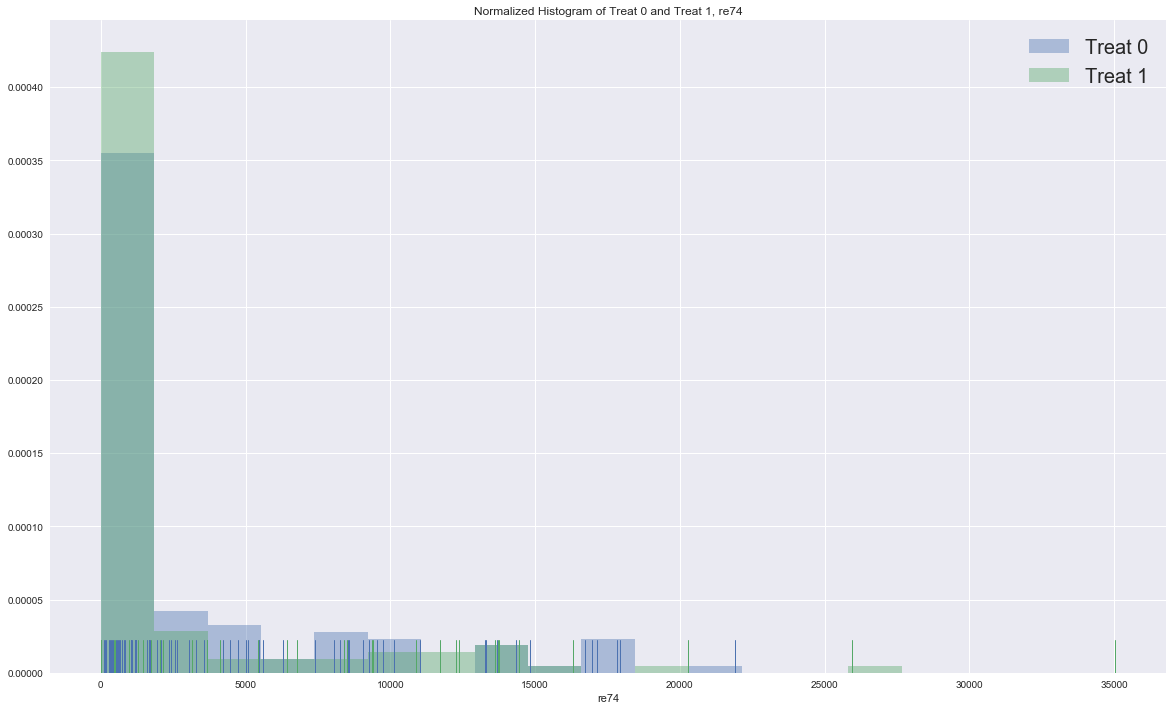

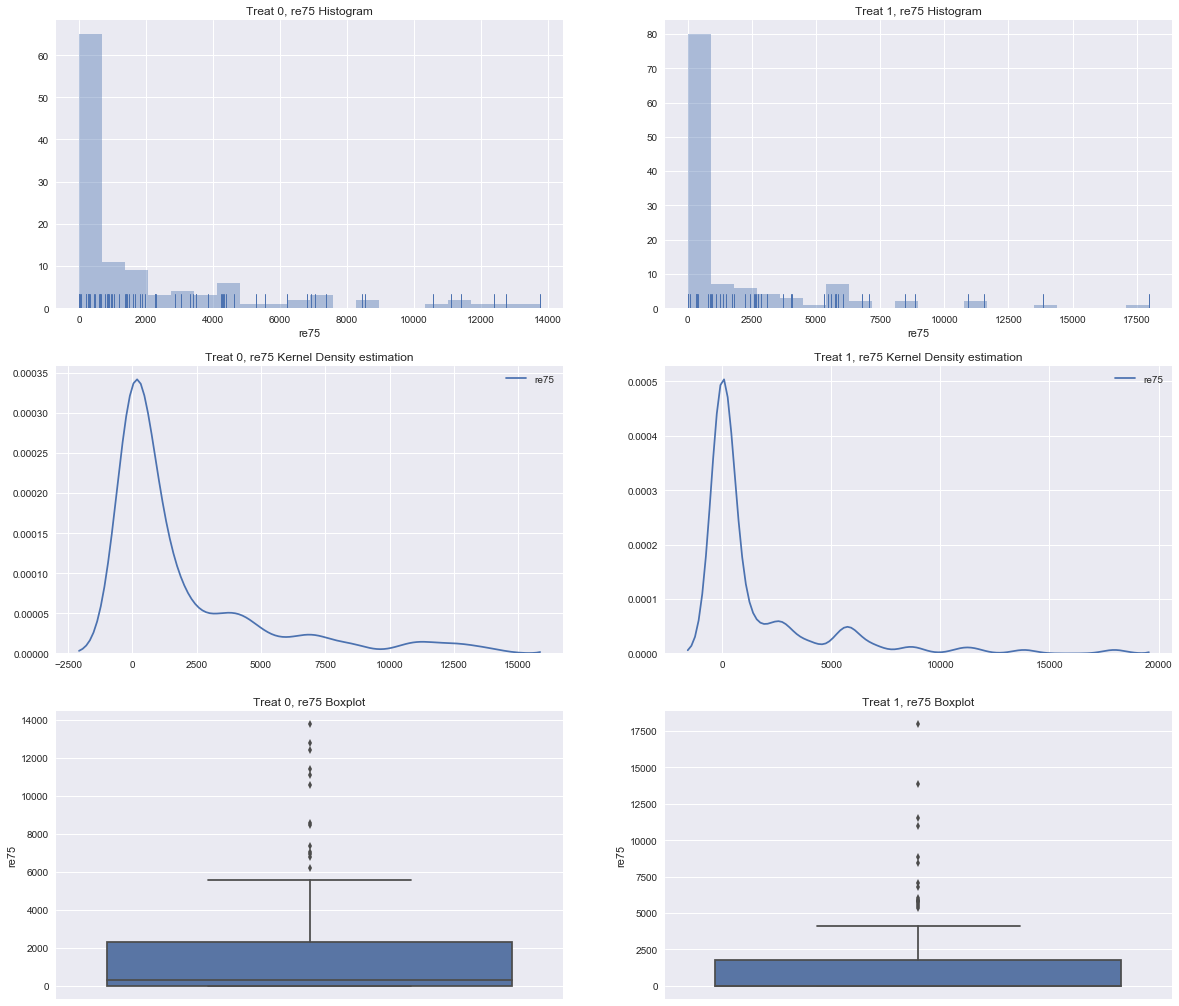

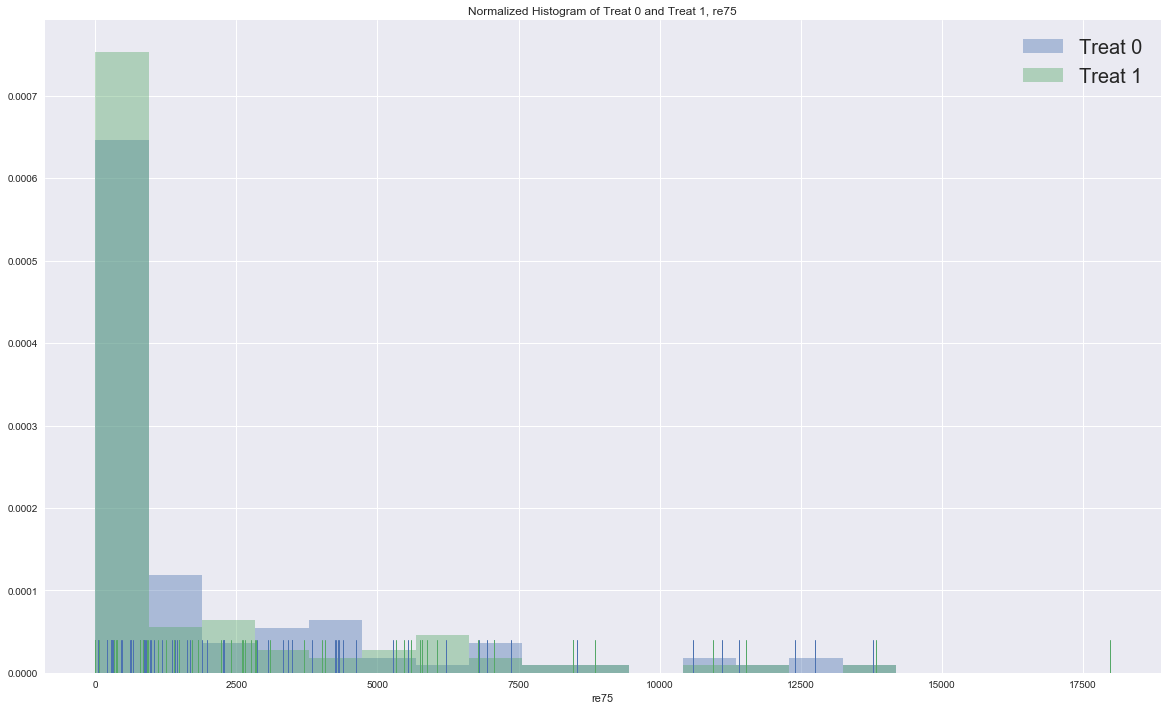

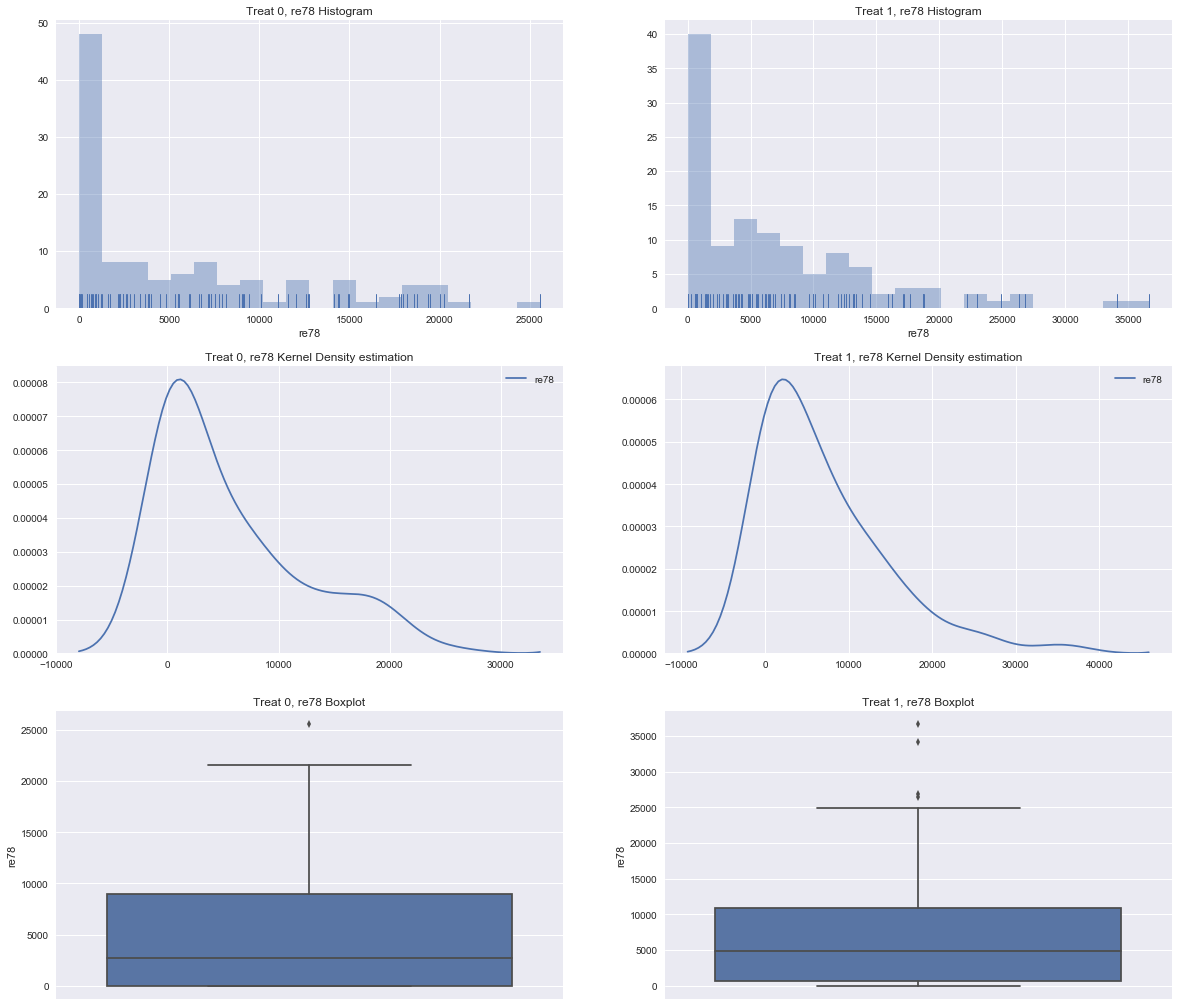

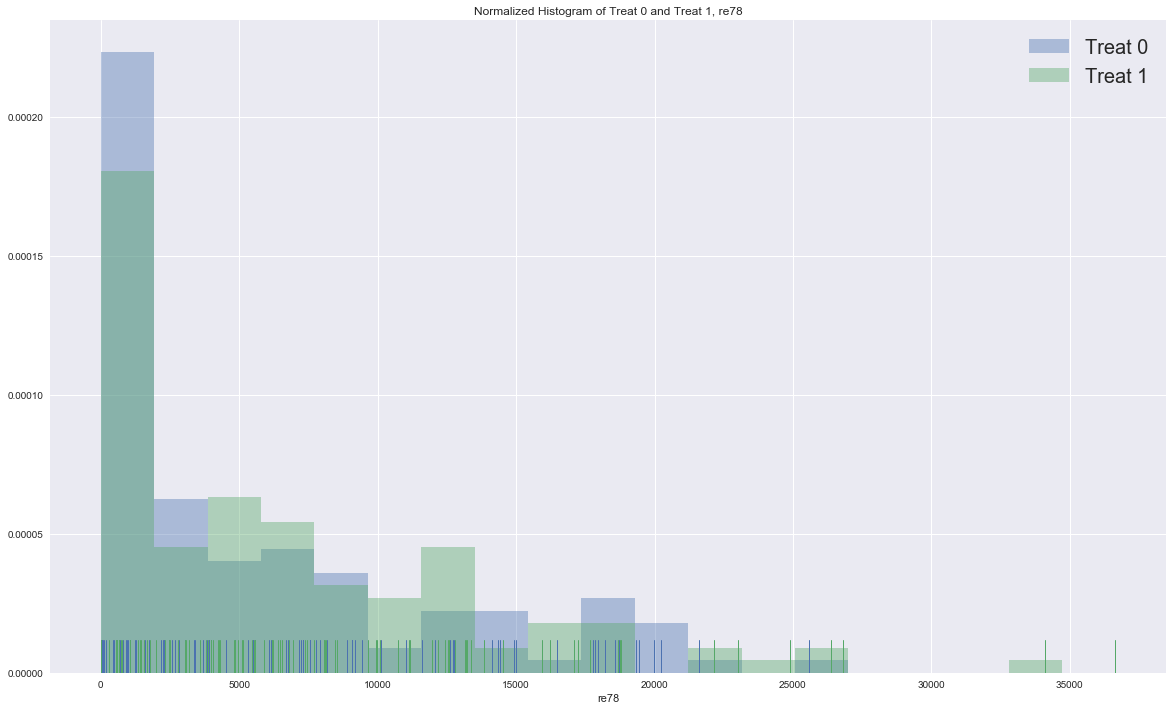

In [61]:
numerical_features = ["age", "educ", "re74", "re75", "re78"]

for col in numerical_features:
    plot_numerical_features(control_matched_2, treat_matched_2, col)
    plot_two_histograms(control_matched_2, treat_matched_2, col)

By looking at the numerical values and plots of the features, one can see that distribution of control_matched_2 group is more similar to treat group than control group before matching or control_matched group and the similarity is high enough to draw a concusion about the outcome "re78".

For age distribution means are almost the same, 25.45 for control_matched_2 and 26.27 treat_matched_2 groups. Moreover, examining the plots, we see that for control_matched_2 group the left and right of the plot are more populated which means that there are more young and more old people in control_matched group whereas ratio of mid age people is significantly higher in treat_matched group. Note that, there are very few old people in treat group whereas there are quite a few old people in control group. After matching, two distributions are more similar although not perfect. By not forgetting the age difference in age distributions and being careful about that subtly, one can draw a conclusion about the effect of treatment on the outcome re78 if all other features are distributed in a similar fashion.

For education distribution means are very similar, 10.12 for control_matched_2 and 10.26 treat_matched_2 groups. Moreover, examining the plots, we see that for control_matched_2 and treat_matched_2 are distbuted very similarly which makes drawing a conclusion possible. Note that, distributions are more similar than procedures tried before. So indeed matching black and non-black people separately helps to balance two groups.

For re74 distribution means are not that close but it is not a problem, means are 3212 for control_matched_2 and 2443 for treat_matched_2 groups. The distributions are far than each other after constraiont on race, but as for control group salaries are in general higher in 1974 and we want to draw a conclusion about effect of job training program on salaries in 1978, having a boost in 1978 for treat_matched_2 group means a lot more as they were earning less in 1974. Actually, the reason these people in job training program after all is they need a boost in their salary. So, being careful about that subtly, one can still draw a conclusion about effect of job training program on the salary in 1978 if the conclusion is job training helps to boost the salary. The similar discussion is valid for re75 as well.

For re75 distribution means are not that close but it is not a problem, means are 1909 for control_matched_2 and 1506 for treat_matched_2 groups. The distributions are far than each other after constraiont on race, but as for control group salaries are in general higher in 1974 and we want to draw a conclusion about effect of job training program on salaries in 1978, having a boost in 1978 for treat_matched_2 group means a lot more as they were earning less in 1975. Actually, the reason these people in job training program after all is they need a boost in their salary. So, being careful about that subtly, one can still draw a conclusion about effect of job training program on the salary in 1978 if the conclusion is job training helps to boost the salary. The similar discussion is valid for re74 as well.

For racial distribution, treat_matched and control_matched groups (or treat and control groups) used to differ a lot. After matching black and non-black people separately, ratio of races in two groups are as follows: 16% white, 75% black, 9% hispanic in control group and 20% white, 75% black and 6% hispanic in treat group. Then one can conclude that racial distributions of treat_matched_2 and control_matched_2 groups are almost the same with small difference for hispanic population which is negligible, so there is no problem for drawing a conclusion about the effect of treatment on re78 in the view of racial distribution.

For married distribution, 26.7% of control_matched_2 group and 25.9% of treat_matched_2 group is married. The distributions of married feature are the same in both groups, so there is no problem for drawing a conclusion about the effect of treatment on re78 in the view of married feature distribution.

For nodegree distribution, 62% of control_matched_2 group and 69% of treat_matched_2 group have no degree. Although there is a small difference, it is not a problem. Intuitively, having a degree is related with higher income. Control group having a degree with higher ratio does not hurt the conclusing if it is about positive effect of job training program on the salary in 1978. 

Propensity scores are distributed similarly for both groups which again suggests that feature distrubitions are similar for both groups. 

As explained above matching black and non-black people separately helped a lot to make feature distributions more similar for treat_matched_2 and control_matched_2 groups. So we are closer to being able to draw valid conclusions now than we were before, although there is still a room for improvement especially for age, re74 and re75 features (note that balancing these are very hard unlike black feature). We argue above that, the balancing is now better to draw a conclusion about the effect of job training program on salary in 1978.

## 6. A less naive analysis - same as 5.2.

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.

What do you conclude about the effectiveness of the job training program?

**Steps**

1) Check distribution of "re78" in control_matched_2 and treat_matched_2 groups using describe() functionality of pandas.

2) Check distribution of "re78" in control_matched_2 and treat_matched_2 groups using plot_numerical_features and plot_two_histograms functions given above.

3) Make comments on results.

Compare numerical results for control_matched_2 and treat_matched_2 groups in terms of real earnings in 1978 to see if job training program is effective.

In [62]:
treat_matched_2["re78"].describe()

count      116.000000
mean      6926.659090
std       7588.465182
min          0.000000
25%        666.459125
50%       4892.512500
75%      10846.230000
max      36646.950000
Name: re78, dtype: float64

In [63]:
control_matched_2["re78"].describe()

count      116.000000
mean      5541.079675
std       6498.524197
min          0.000000
25%          0.000000
50%       2742.660500
75%       8942.092750
max      25564.670000
Name: re78, dtype: float64

In [64]:
print("Number of unemployed people in treat group after the second match: {}".format(treat_matched_2[treat_matched_2["re78"] == 0].shape[0]))
print("Number of unemployed people in control group after the second match: {}".format(control_matched_2[control_matched_2["re78"] == 0].shape[0]))

Number of unemployed people in treat group after the second match: 24
Number of unemployed people in control group after the second match: 30


Compare plots of results for control_matched_2 and treat_matched_2 groups in terms of real earnings in 1978 to see if job training program is effective.

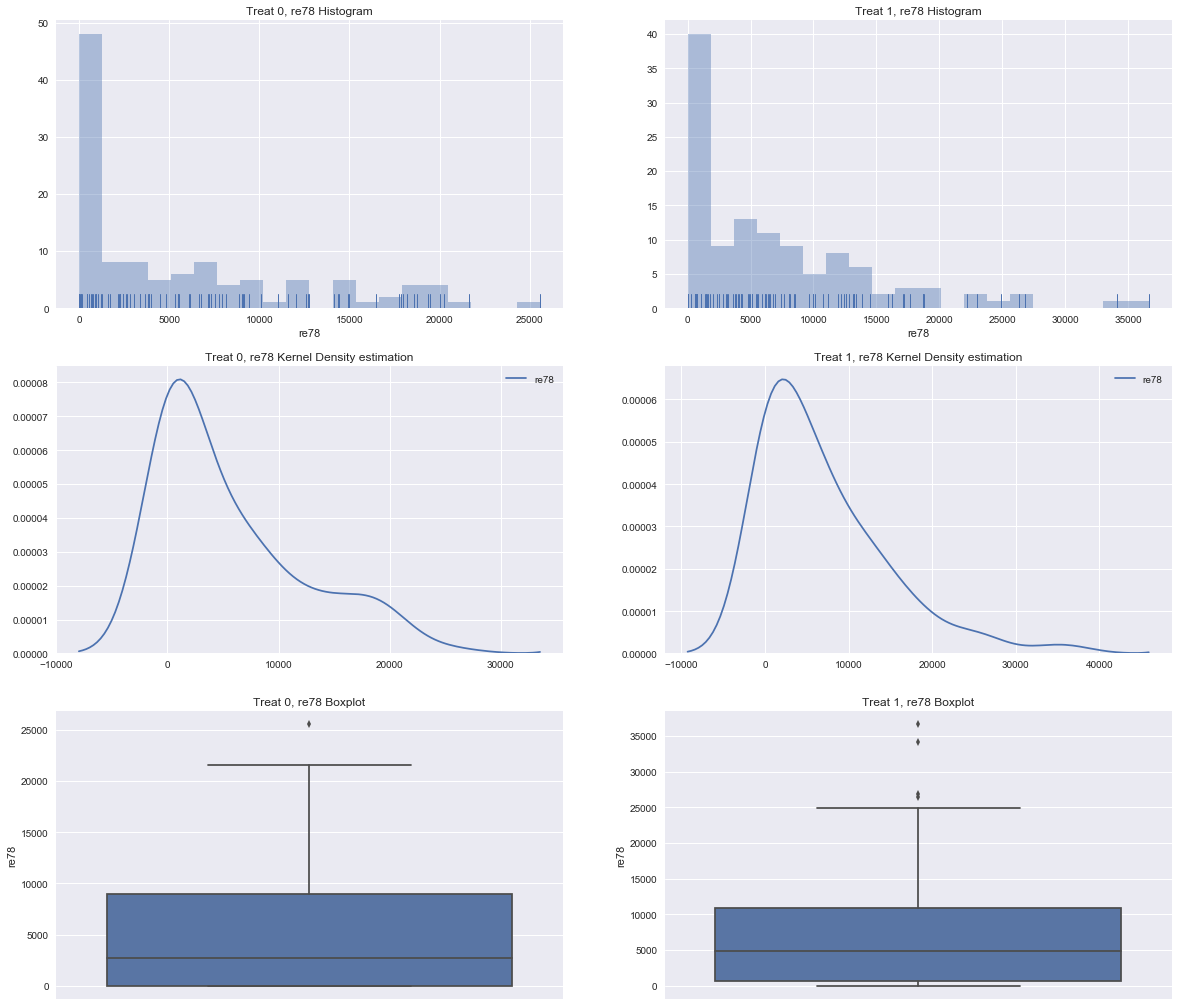

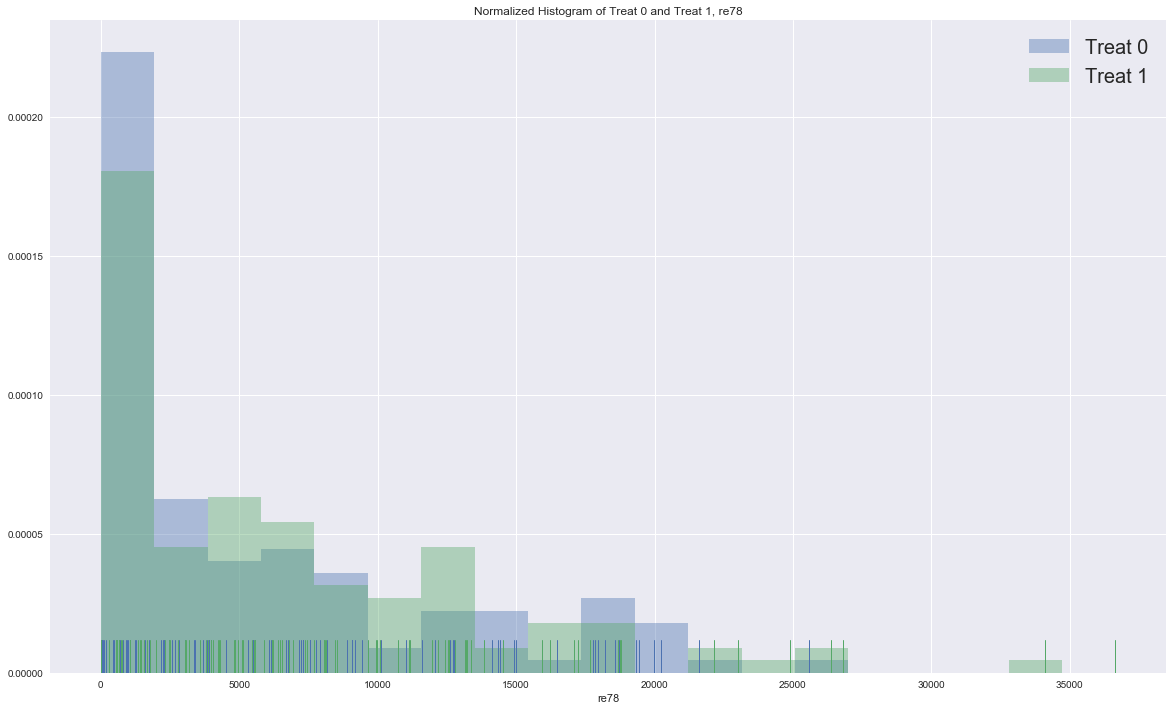

In [65]:
plot_numerical_features(control_matched_2, treat_matched_2, "re78")
plot_two_histograms(control_matched_2, treat_matched_2, "re78")

First observe that, our treat_matched_2 and control_matched_2 sizes are 116 as there black people in treat group excluded because of lack of enough black people in control group to match.

From the results above, we see that mean income is for treat_matched_2 and 6926 and 5541 for control_matched_2 which means 25% higher for treat_matched_2. Also both median and maximum values are higher for treat_matched_2 than control_matched_2 (medians are 4892 and 2742, and maximums are 36646 and 25564  for treat_matched_2 and control_matched_2, respectively). Number of unemployed people is 30 for control_matched_2 and 24 for treat_matched_2. Moreover, examining the histogram one can see that the right of the plot is more populated by treat_matched_2 than control_matched_2. All of these suggest that for the treat_matched_2 group the salary in 1978 is isgnificantly better than control_matched_2 group. One can draw a conclusion from this observational study by stating that job training programs are effective for increasing salary of people in treat_matched_2 group compared to control_matched_2 group as their features has very simialar distributions, thus, drawing a such conclusion is not naive unlike in the first questions we answered.

From the question we learned that one should carefully examine distribution of features among two groups, treat and control, before drawing a conclusion about the effect of treatment. As features are skewed, this might be significant effect on the outcome which would hurt the conclusion. Therefore, before drawing such conslusion one should carefully do the steps necessary for good observational studies, for example; creating balance between groups, examining the feature distributions for each group, using propensity score to balance groups and making further balance by putting a constraints on one or some of the feature(s). After that, one can try to draw a statistically significant conclusion using his/her observations.

# Question 2

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

**Steps**

1) Download the dataset using sklearn.datasets.fetch_20newsgroups

2) Find TF-IDF features for the data using sklearn.feature_extraction.text.TfidfVectorizer

3) Split data into train, validation and test set with 80%, 10% and 10% of the actual data using sklearn.model_selection.train_test_split

4) Train a Random Forest Classfier using sklearn.ensemble.RandomForestClassifier with different hyperparameter selections for n_estimators and max_depth. Use grid search (for each hyperparameter combination train the classifier on the train data, find the accuracy on the validation data) to find the best hyperparameter combination for n_estimators and max_depth To find the accuracies on the validation set use sklearn.metrics.accuracy_score. Display accuracies for different hyperparameter combinations as a heatmap.

5) Using the model with the highest accuracy on the validation set (n_estimators and max_depth values) train a new classifier on the train set, test the model on the test set. Report accuracy on the test. Find the confusion matrix for the classifier using sklearn.metrics.confusion_matrix

6) Examine feature importances using feature\_importances\_ method of the RandomForestClassifier. Plot histograms for feature importances to understand better.

7) Find the most relevant features (in this case words) for classification. Plot most relevant features with their corresponding relevance scores. 

8) Make comments on the results.

Download the dataset and examine its structure. It has 18,846 newsgroup documents, from 20 different newsgroups. It has different fields, which are given below.

* `data`: text description of the news
* `filenames`: location of the dataset on the computer as path
* `target_names`: names of targets 
* `target`: labels as intergers from 0 to 19, each denoting one of the target_names
* `DESCR`: empty
* `description`: description of the dataset

## 1. TF-IDF Features, Train-Validation-Test Split

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


Fetch the data

In [66]:
data_news = fetch_20newsgroups(subset="all")

Print the fields in the data

In [67]:
print(list(data_news.keys()))

['data', 'filenames', 'target_names', 'target', 'DESCR', 'description']


Print number of elemens in the data

In [68]:
len(data_news.data)

18846

Print the target_names in the data. These are labels on which we want to classify news.

In [69]:
data_news.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Find TF-IDF features of the whole data. Print number of features (number of distinct words in the whole data in this case).

In [70]:
tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(data_news.data) 
len(tfidf.vocabulary_)

173762

Split the data into train, validation and test set according to given ratios.

In [71]:
train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

x_train, x_, y_train, y_ = train_test_split(x_tfidf, data_news.target, train_size=train_ratio, test_size=1-train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_, y_, train_size=validation_ratio/(validation_ratio+test_ratio), test_size=test_ratio/(validation_ratio+test_ratio))

Check size of each split.

In [72]:
x_train

<15076x173762 sparse matrix of type '<class 'numpy.float64'>'
	with 2357092 stored elements in Compressed Sparse Row format>

In [73]:
x_test

<1885x173762 sparse matrix of type '<class 'numpy.float64'>'
	with 292955 stored elements in Compressed Sparse Row format>

In [74]:
x_val

<1885x173762 sparse matrix of type '<class 'numpy.float64'>'
	with 302487 stored elements in Compressed Sparse Row format>

## 2. Training Random Forest

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

Set grid in which n_estimators and max_depth take values. Use logarithmic scale as linear scale does not change much for even moderate values of n_estimators and max_depth (for example, having max_depth 150 or 152, or having n_estimators 80 or 83 do not mean much). 

In [79]:
# set possible hyperparemeters
grid_n_estimators = np.ceil(np.logspace(1, 3, 10)).astype(int)
grid_max_depth = np.ceil(np.logspace(1, 2.5, 10)).astype(int)
# initialize accuracies
accuracies = np.zeros((grid_n_estimators.shape[0], grid_max_depth.shape[0]))

For each possible hyperparameter combination, train a RandomForestClassifier on the train set. Find its accuracy on the validation set and store this accuracy on the accuracies array.

In [80]:
# traverse all possible hyperparameter combinations
for i, n in enumerate(grid_n_estimators):
    for j, depth in enumerate(grid_max_depth):
        print("Training for n_estimator = {} and max_depth = {}".format(n, depth))
        # initialize random forest classifier
        rf_clf = RandomForestClassifier(n_estimators=n, max_depth=depth)
        # fit the data
        rf_clf.fit(x_train, y_train)
        # predict on validation set
        y_val_pred = rf_clf.predict(x_val)
        # store on accuracies
        accuracies[i, j] = accuracy_score(y_val_pred, y_val)

Training for n_estimator = 10 and max_depth = 10
Training for n_estimator = 10 and max_depth = 15
Training for n_estimator = 10 and max_depth = 22
Training for n_estimator = 10 and max_depth = 32
Training for n_estimator = 10 and max_depth = 47
Training for n_estimator = 10 and max_depth = 69
Training for n_estimator = 10 and max_depth = 100
Training for n_estimator = 10 and max_depth = 147
Training for n_estimator = 10 and max_depth = 216
Training for n_estimator = 10 and max_depth = 317
Training for n_estimator = 17 and max_depth = 10
Training for n_estimator = 17 and max_depth = 15
Training for n_estimator = 17 and max_depth = 22
Training for n_estimator = 17 and max_depth = 32
Training for n_estimator = 17 and max_depth = 47
Training for n_estimator = 17 and max_depth = 69
Training for n_estimator = 17 and max_depth = 100
Training for n_estimator = 17 and max_depth = 147
Training for n_estimator = 17 and max_depth = 216
Training for n_estimator = 17 and max_depth = 317
Training for

In [81]:
np.save("accuracies", accuracies)

Print accuracies.

In [82]:
accuracies

array([[ 0.37559682,  0.48381963,  0.54748011,  0.59734748,  0.61591512,
         0.65464191,  0.63289125,  0.67002653,  0.67161804,  0.65623342],
       [ 0.47480106,  0.56339523,  0.64190981,  0.67639257,  0.71618037,
         0.75649867,  0.74854111,  0.74960212,  0.73262599,  0.73846154],
       [ 0.55596817,  0.6265252 ,  0.69549072,  0.72095491,  0.74748011,
         0.78355438,  0.79151194,  0.79098143,  0.79310345,  0.78514589],
       [ 0.6535809 ,  0.70185676,  0.74801061,  0.76870027,  0.79416446,
         0.81061008,  0.81485411,  0.8265252 ,  0.82015915,  0.83289125],
       [ 0.67161804,  0.73050398,  0.75702918,  0.79416446,  0.81538462,
         0.83023873,  0.83076923,  0.85198939,  0.83289125,  0.83501326],
       [ 0.71034483,  0.75915119,  0.78779841,  0.80901857,  0.8265252 ,
         0.83607427,  0.84880637,  0.84244032,  0.8530504 ,  0.85251989],
       [ 0.74376658,  0.77241379,  0.78992042,  0.81750663,  0.82970822,
         0.85411141,  0.85888594,  0.85835544

Save and load accuracies to not train models each time running the code. One can train the models from start, if necessary.

In [113]:
np.save("accuracies", accuracies)

In [114]:
accuracies= np.load("accuracies.npy")

Show accuracies for different hyperparameter combinations using heatmap.

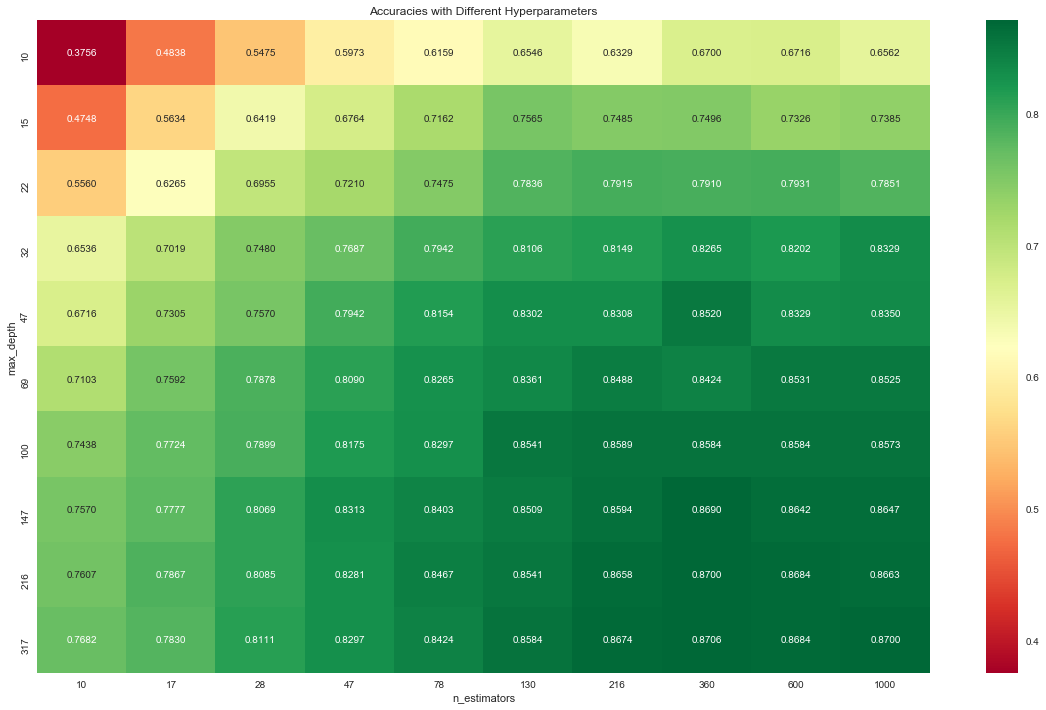

In [115]:
# plot accuracies as heatmap; name title, labels etc
plt.figure(figsize=(20, 12))
ax = sns.heatmap(accuracies, xticklabels=grid_n_estimators, yticklabels=grid_max_depth, annot=True, fmt=".4f", cmap='RdYlGn')
ax.set_title("Accuracies with Different Hyperparameters");
ax.set_xlabel("n_estimators");
ax.set_ylabel("max_depth");

As one can see from the above, generally speaking increasing number of estimators and maximum depth give a better classfication accuracy. However, the best classfication accuracy is achieved by n_estimators=360 and max_depth=317 for the hyperparameters we tried, which means increasing the parameters does not always give a better result. After a while, classifier overfits to train data which degrades its performance in validation dataset. For example, increasing number of estimators does not help after a while for max_depth=317. Note that, there might be hyperparameter combination other than what we tried in grid search which gives a better classfication accuracy, but classifier has already top level performance (note that classification accuracy does not change much and even drops if you change max_depth or n_estimators around the best hyperparameter combination, in other words, classification accuracy makes a plateau around best hyperparameter combination).

Find the best parameters by first finding the argument maximizing the element of accuracies and then finding corresponding n_estimators and max_depth.

In [99]:
# find best indexes and find best parameters
best_depth_index, best_n_index = np.unravel_index(accuracies.argmax(), accuracies.shape)
best_n, best_depth = grid_n_estimators[best_n_index], grid_max_depth[best_depth_index]
print("Best parameters are: n_estimators = {}, max_depth = {}".format(best_n, best_depth))

Best parameters are: n_estimators = 360, max_depth = 317


Train a RandomForestClassifier on the train set using the best hyperparameter combination. Find the accuracy on the test set, report the accuracy.

In [100]:
# train with best parameters
rf_clf = RandomForestClassifier(n_estimators=best_n, max_depth=best_depth)
rf_clf.fit(x_train, y_train)
# predict on test set, report accuracy
y_test_pred = rf_clf.predict(x_test)
print('Accuracy on test set is {:.4f}'.format(accuracy_score(y_test_pred, y_test)))

Accuracy on test set is 0.8637


We see that Random Forest Classifier with parameters n_estimators = 360 and max_depth = 317 has accuracy of 0.8637 in test set, which is comparable with its performance of validation set, 0.8706.

Find the confusion matrix, normalize it to find ratio of true and false positives. Display the confusion matrix using heatmap.

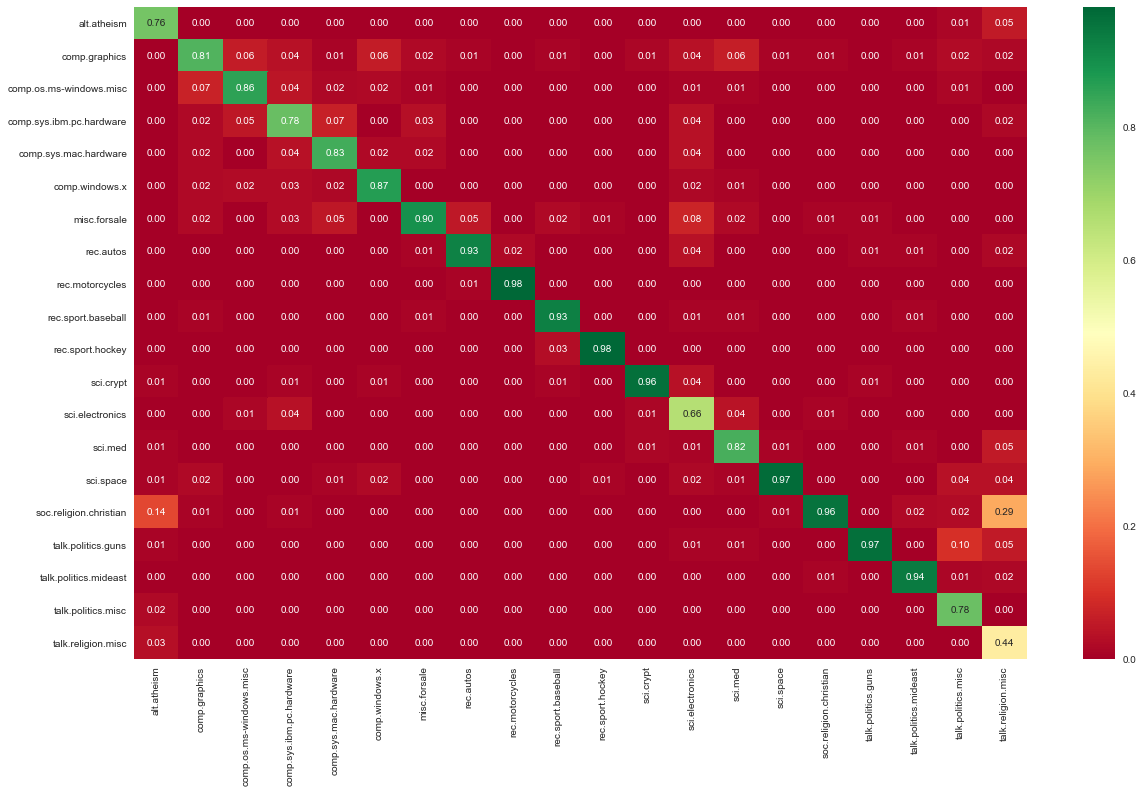

In [101]:
# construct confusion matrix
cm = confusion_matrix(y_test_pred, y_test)
cm_normalized = cm / cm.sum(axis=0)
# display as heatmap 
plt.figure(figsize=(20, 12))
ax = sns.heatmap(cm_normalized, xticklabels=data_news.target_names, yticklabels=data_news.target_names, annot=True, fmt=".2f", cmap='RdYlGn')

From the confusion matrix above, we see that classification accuracy for some of target names are significantly higher than others. For example, there are target names with classification accuracy more than 0.95 such as rec.motorcycles, rec.sport.hockey, sci.crypt, sci.space, soc.religion.christian, talk.politics.guns. The reason for these topics to be classified with high accuracy might be their non-relevance with other topics. However, there are some topics which have very degraded classification accuracy. For example, talk.religion.misc news sometimes has been classified as soc.religion.christian which is quite intuitively as these topics are highly related and some contents might be overlapping. Similar relation can be seen between talk.politics.misc-talk.politics.guns and alt.atheism-soc.religion.christian. Moreover, sci.electronics-misc.forsale-comp.sys.ibm.pc.hardware-comp.sys.mac.hardware-comp.os.ms-windowns.misc are all related topics which can contain same words and phrases and there is an significant error between these target names. Summing all up, we can say that although classifier has very good performance in general it has a worse performance when classifiying some of the target names and these topics are generally ones which are similar to other topics. As a results, there are significant number of misclassifications between these topics (for example, atheism vs christianity can have similar contents, thus, more error between each other) because of overlapping content, as expected intuitively. 

Find feature importances and make histograms to understand it better.

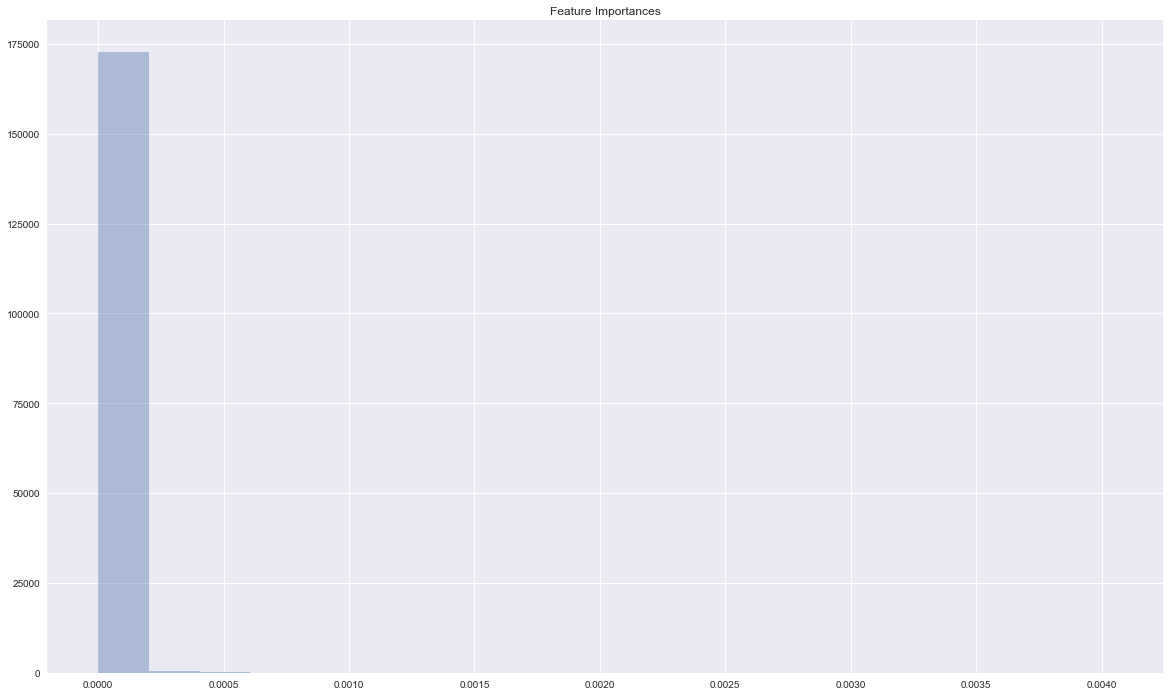

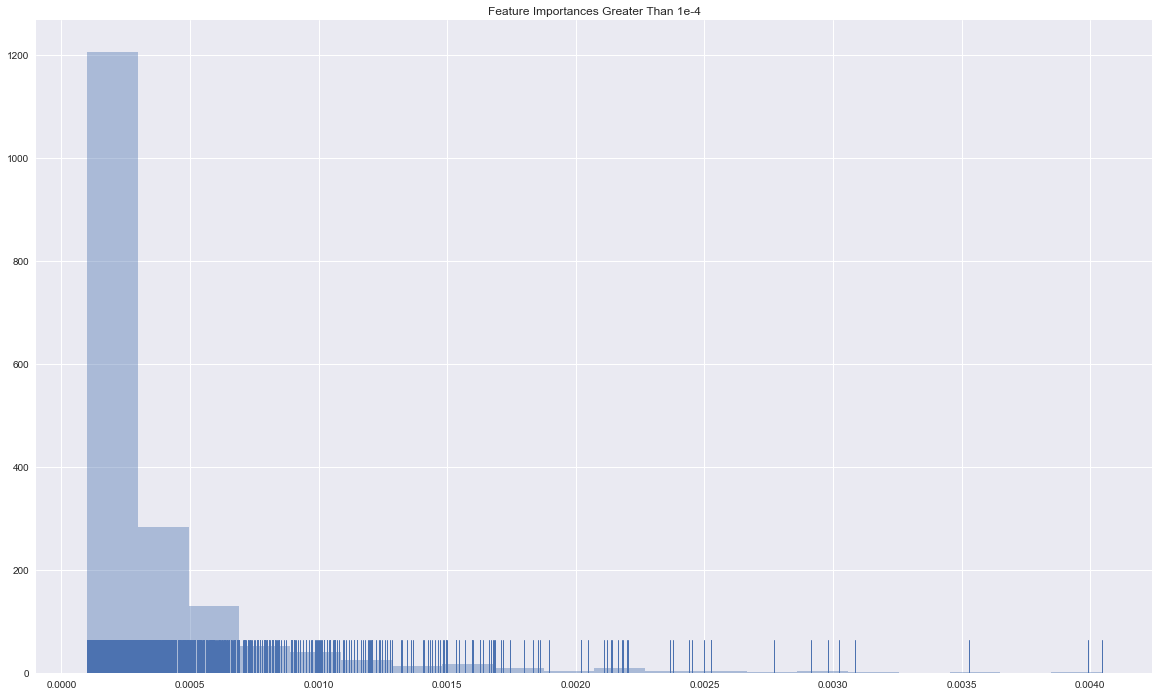

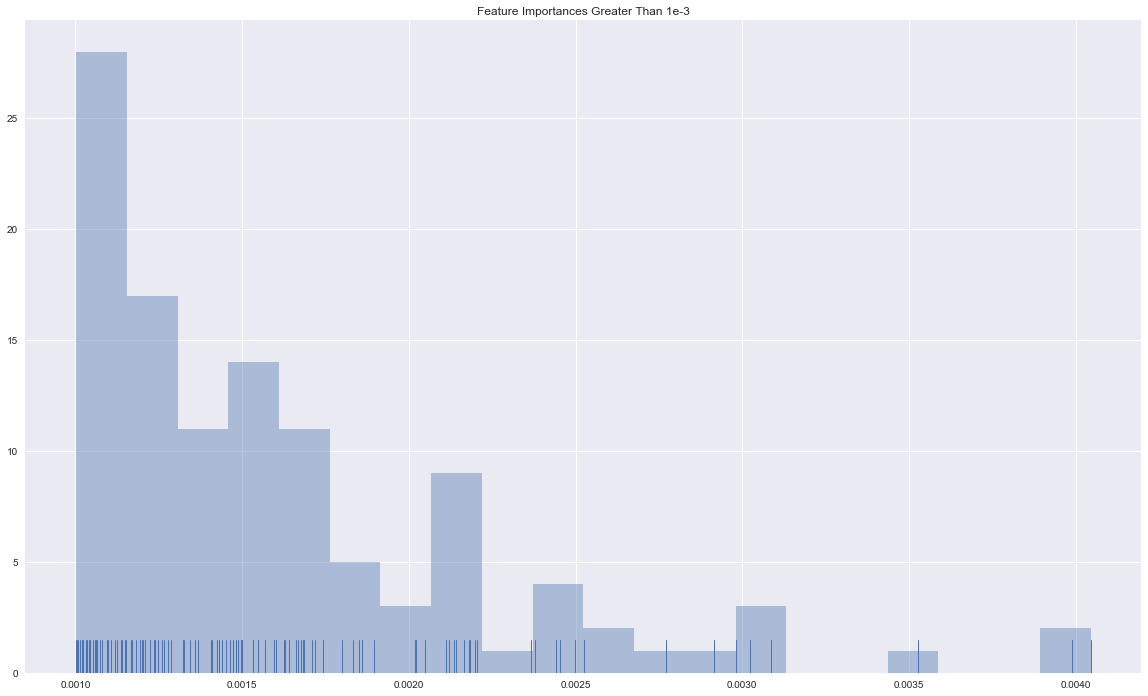

In [104]:
# take feature importances
feature_importances = rf_clf.feature_importances_

# plot feature importances as histogram
plt.figure(figsize=(20,12))
sns.distplot(feature_importances, bins=20, kde=False).set_title("Feature Importances");
plt.figure(figsize=(20,12))
sns.distplot(feature_importances[feature_importances>1e-4], bins=20, rug=True, kde=False).set_title("Feature Importances Greater Than 1e-4");
plt.figure(figsize=(20,12))
sns.distplot(feature_importances[feature_importances>1e-3], bins=20, rug=True, kde=False).set_title("Feature Importances Greater Than 1e-3");

We can see that there are handful of features which are really that important and almost all other features are highly irrelevant considering thier importance scores. 

Find the most relevant features (words in this case). Print and plot most relevant features with their corresponding relevance score.

In [109]:
# find most relevant features with their scores
num_of_features = 100
most_relevant_feature_ids = np.argsort(-feature_importances)[:num_of_features]
most_relevant_feature_scores = -np.sort(-feature_importances)[:num_of_features]
most_relevant_features = np.array(tfidf.get_feature_names())[most_relevant_feature_ids]

In [110]:
most_relevant_features

array(['sale', 'windows', 'dod', 'bike', 'car', 're', 'of', 'the', 'in',
       'that', 'encryption', 'to', 'clipper', 'is', 'space',
       'organization', 'edu', 'lines', 'god', 'graphics', 'for', 'hockey',
       'from', 'subject', 'mac', 'game', 'and', 'writes', 'it', 'cars',
       'israel', 'com', 'article', 'on', 'not', 'posting', 'be', 'host',
       'you', 'nntp', 'he', 'apple', 'this', 'have', 'university', 'gun',
       'my', 'athos', 'baseball', 'team', 'was', 'israeli', 'with', 'if',
       'are', 'can', 'or', 'but', 'key', 'they', 'rutgers', 'christian',
       'window', 'any', 'as', 'what', 'thanks', 'there', 'about', 'who',
       'distribution', 'at', 'me', 'we', 'offer', 'would', 'motif', 'by',
       'all', 'chip', 'an', 'players', 'shipping', 'do', 'nhl', 'people',
       'know', 'government', 'ride', 'dos', 'one', 'drive', 'no', 'anyone',
       'has', 'games', 'out', 'orbit', 'ca', 'so'], 
      dtype='<U180')

In [111]:
most_relevant_feature_scores

array([ 0.00404458,  0.0039899 ,  0.00352754,  0.00308482,  0.00302446,
        0.00298035,  0.00291547,  0.00277155,  0.00252608,  0.00252456,
        0.00249947,  0.00245325,  0.00244164,  0.00237681,  0.00236671,
        0.00220437,  0.00219941,  0.00218479,  0.00217937,  0.00216392,
        0.00214088,  0.00213551,  0.00211988,  0.00211056,  0.00204724,
        0.00202111,  0.00201848,  0.00189551,  0.00186061,  0.00185174,
        0.00183221,  0.00179919,  0.00174394,  0.00171752,  0.00170954,
        0.00168481,  0.00168136,  0.00167648,  0.00166867,  0.00166244,
        0.0016401 ,  0.00162848,  0.00162696,  0.00160183,  0.00159697,
        0.0015964 ,  0.00156998,  0.00154763,  0.00153375,  0.00153327,
        0.00150077,  0.00149709,  0.00149605,  0.00148851,  0.00148254,
        0.00147126,  0.00146252,  0.00145299,  0.00144027,  0.00143167,
        0.00142477,  0.00141057,  0.00140604,  0.00136774,  0.0013587 ,
        0.00134468,  0.00132508,  0.00132139,  0.0012867 ,  0.00

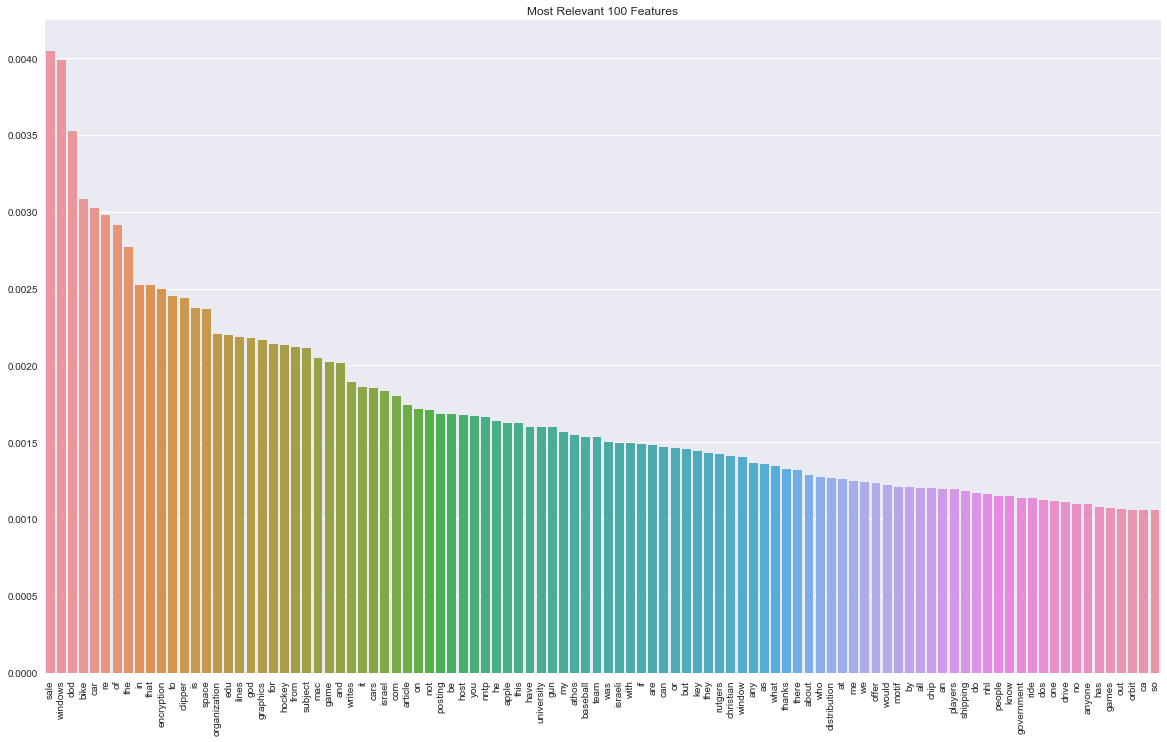

In [112]:
# plot most relevant features with their scores
plt.figure(figsize=(20,12))
sns.barplot(x=most_relevant_features, y=most_relevant_feature_scores, orient="v").set_title("Most Relevant {} Features".format(num_of_features))
plt.xticks(rotation=90);

Most relevant 100 words are plotted above with their corresponding relevance score. There are words which are highly related with some of the target names. For example encryption is highly indicative of sci.crypt, graphics is highly indicative of comp.graphics, windows is highly indicative of comp.os.ms-windowns.misc, hockey is highly indicative of rec.sport.hockey etc. There are similar other words which are highly indicative of specific target names. However, there are words like of, the, in, is, to etc. which have higher relevance scores which is quite interesting. These words are called stop words and generally omitted in such text classification tasks due to their common usage and non-specificity of the content. The reason these words have high relevance score for our task might be some of topics might have longer texts which contains more of these stop words. Then, number of such words would be indicative of topic and their relevance score are high.